In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
from scipy import signal, stats

import IPython.display
import cmocean as cm
import sys, os, glob
import warnings
warnings.simplefilter("ignore") 

from IPython.display import Image

from dask.distributed import Client

from matplotlib.patches import Rectangle

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['font.size'] = 15
letlab = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)',
          '(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)',
          '(q)','(r)','(s)','(t)','(u)','(v)','(w)','(x)',
          '(y)','(z)']

In [3]:
# Load workers:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42479/status,
Dashboard: /proxy/42479/status,Workers: 28
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37793,Workers: 28
Dashboard: /proxy/42479/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:44829,Total threads: 1
Dashboard: /proxy/36681/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45937,


## Load datasets and utilities

In [4]:
base = '/g/data/e14/rmh561/croco/'
base_data = base + 'archive/'
base_analysis = base + '/analysis/'

os.chdir(base_analysis + 'PAC12_75_cpl')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts')
sys.path.append(base_analysis + 'PAC12_75_cpl/Processing_Scripts/Tracer_balance_code_LMaillard_v2')

In [5]:
# Load custom scripts/tools:
import pac12_tools as ptools
import R_tools_fort as ftools

In [ ]:
# Reload (if needed):
import importlib
importlib.reload(ptools)

In [6]:
# define runs:
expdict = {
# CROCO-WRF runs:
           'CROCO-WRF Control-E1':{'exp':'PAC12_75_cpl','expn':'exp02','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF Control-E2':{'exp':'PAC12_75_cpl','expn':'exp08','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF Control-E3':{'exp':'PAC12_75_cpl','expn':'exp09','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
           ,'CROCO-WRF Control-E4':{'exp':'PAC12_75_cpl','expn':'exp10','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF Control-E5':{'exp':'PAC12_75_cpl','expn':'exp11','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoTFB-E1':{'exp':'PAC12_75_cpl','expn':'exp12','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoTFB-E2':{'exp':'PAC12_75_cpl','expn':'exp14','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoTFB-E3':{'exp':'PAC12_75_cpl','expn':'exp17','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
           ,'CROCO-WRF NoTFB-E4':{'exp':'PAC12_75_cpl','expn':'exp20','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoTFB-E5':{'exp':'PAC12_75_cpl','expn':'exp23','CPL':True,'TSoffset': 2014.,'TIWoutput':False} # Actually do have TIWoutput
           ,'CROCO-WRF NoMesoCFB-E1':{'exp':'PAC12_75_cpl','expn':'exp13','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoMesoCFB-E2':{'exp':'PAC12_75_cpl','expn':'exp15','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoMesoCFB-E3':{'exp':'PAC12_75_cpl','expn':'exp18','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
           ,'CROCO-WRF NoMesoCFB-E4':{'exp':'PAC12_75_cpl','expn':'exp21','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoMesoCFB-E5':{'exp':'PAC12_75_cpl','expn':'exp24','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoCFB-E1':{'exp':'PAC12_75_cpl','expn':'exp26','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
           ,'CROCO-WRF NoCFB-E2':{'exp':'PAC12_75_cpl','expn':'exp27','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoCFB-E3':{'exp':'PAC12_75_cpl','expn':'exp28','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoCFB-E4':{'exp':'PAC12_75_cpl','expn':'exp29','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           ,'CROCO-WRF NoCFB-E5':{'exp':'PAC12_75_cpl','expn':'exp30','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           # ,'CROCO-WRF NoCFB-E1':{'exp':'PAC12_75_cpl','expn':'exp06','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           # ,'CROCO-WRF NoCFB-E2':{'exp':'PAC12_75_cpl','expn':'exp16','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           # ,'CROCO-WRF NoCFB-E3':{'exp':'PAC12_75_cpl','expn':'exp19','CPL':True,'TSoffset': 2014.,'TIWoutput':True}
           # ,'CROCO-WRF NoCFB-E4':{'exp':'PAC12_75_cpl','expn':'exp22','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
           # ,'CROCO-WRF NoCFB-E5':{'exp':'PAC12_75_cpl','expn':'exp25','CPL':True,'TSoffset': 2014.,'TIWoutput':False}
# CROCO-only runs:
#           ,'CROCO Control':{'exp':'PAC12_75','expn':'exp11','CPL':False,'TSoffset': 2014.}
#          ,'CROCO PP81':{'exp':'PAC12_75','expn':'exp12','CPL': False,'TSoffset': 2014.}
          }
cont = 'CROCO-WRF Control-E1'
eL = 5

In [7]:
# Load CROCO data:
data_typs = ['mon','day','mon_hp','mon_TIWhp','mon_TIWhpstd']#'3day','day','ts_3day']
dropvars = {'mon':['omega','u_sq','v_sq','salt_sq','AKv'],
            'day':[],
            '3day':[],
            'ts_3day':[],
            'mon_hp':[],
            'mon_TIWhp':[],
            'mon_TIWhpstd':[]}
dropyears = ['2014']
#dropyears = ['2015','2016','2017','2018']
S1 = 39

data = {}
for nam in expdict.keys():
    print(nam)
    exp = expdict[nam]['exp']
    expn = expdict[nam]['expn']
    data[nam] = {}
    for typ in data_typs:
        try:
            files = sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/croco_out_' + typ + '.nc'))
            for yr in dropyears:
                files = [file for file in files if yr not in file]
            data[nam][typ] = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',drop_variables=dropvars[typ],parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
            
            # Do coordinates:
            if 'TIW' in typ:
                data[nam][typ] = ptools.create_coords_CROCO_TIW(data[nam][typ],grd)
            else:
                data[nam][typ] = ptools.create_coords_CROCO(data[nam][typ])
        except:
            data[nam][typ] = None
gfiles = glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/croco_out_grd.nc')
grd = xr.open_dataset(gfiles[0],chunks={'y_rho':100,'x_rho':100})

# Generate xgcm grid object:
nam = 'CROCO-WRF Control-E1'
grid = Grid(data[nam]['mon'],coords={"x":{"center":"x_rho","inner":"x_u"},
                         "y":{"center":"y_rho","inner":"y_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False)

CROCO-WRF Control-E1
CROCO-WRF Control-E2
CROCO-WRF Control-E3
CROCO-WRF Control-E4
CROCO-WRF Control-E5
CROCO-WRF NoCFB-E1
CROCO-WRF NoCFB-E2
CROCO-WRF NoCFB-E3
CROCO-WRF NoCFB-E4
CROCO-WRF NoCFB-E5
CROCO-WRF NoCFBr-E1
CROCO-WRF NoCFBr-E2
CROCO-WRF NoCFBr-E3
CROCO-WRF NoCFBr-E4
CROCO-WRF NoCFBr-E5


In [8]:
# Load WRF data:
data_typs = {'day':'3d_1D','mon_hp':'3d_1M_hp'}#,'hr':'3d_1H','day4d':'out'}

for nam in expdict.keys():
    if expdict[nam]['CPL']:
        print(nam)
        exp = expdict[nam]['exp']
        expn = expdict[nam]['expn']
        for typ in data_typs.keys():
            try:
                files = sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/*/wrf' + data_typs[typ] + '*.nc'))
                for yr in dropyears:
                    files = [file for file in files if yr not in file]
                data[nam]['wrf_' + typ] = xr.open_mfdataset(files, concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
                
                # Create coords:
                data[nam]['wrf_' + typ] = ptools.create_coords_WRF(data[nam]['wrf_' + typ])
                
            except:
                data[nam]['wrf_' + typ] = None
             
# Create WRF xgcm object:
wrf_grid = ptools.create_WRF_xgcm(data['CROCO-WRF Control-E1']['wrf_day'])

CROCO-WRF Control-E1
CROCO-WRF Control-E2
CROCO-WRF Control-E3
CROCO-WRF Control-E4
CROCO-WRF Control-E5
CROCO-WRF NoCFB-E1
CROCO-WRF NoCFB-E2
CROCO-WRF NoCFB-E3
CROCO-WRF NoCFB-E4
CROCO-WRF NoCFB-E5
CROCO-WRF NoCFBr-E1
CROCO-WRF NoCFBr-E2
CROCO-WRF NoCFBr-E3
CROCO-WRF NoCFBr-E4
CROCO-WRF NoCFBr-E5


In [ ]:
# Set limit parameters for observations:
for nam in expdict.keys():
    try:
        minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
        maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
        print(nam + ' minyr=' + str(minyr) + ' maxyr=' + str(maxyr))
    except:
        print('No data for ' + nam)
nam = 'CROCO-WRF Control-E1'
minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
minlon = data[nam]['mon'].x_rho.min('x_rho').values
maxlon = data[nam]['mon'].x_rho.max('x_rho').values
minlat = data[nam]['mon'].y_rho.min('y_rho').values
maxlat = data[nam]['mon'].y_rho.max('y_rho').values

## Domain Schematic:

In [12]:
# Observational SST:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += sorted(glob.glob('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*_' + str(yr) + '.nc'))
OISST = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True).isel(zlev=0)

OISST = OISST.sel(lon=slice(minlon,maxlon)).sel(lat=slice(minlat,maxlat))
OISST = OISST.rename({'lon':'x_rho','lat':'y_rho'})

In [ ]:
time = '2016-11-01'
plt.figure(figsize=(10,5))

# EPAC only:
xlims = [115.,300.]
ylims = [-35.,35.]
vlims = [18.,30.]

# EPAC and BPAC:
xlims = [100.,300.]
ylims = [-35.,35.]
vlims = [18.,30.]

ps = OISST.sst.sel(x_rho=slice(xlims[0],xlims[1])).sel(y_rho=slice(ylims[0],ylims[1])).sel(time=time).plot(cmap=cm.cm.thermal,vmin=vlims[0],vmax=vlims[1],cbar_kwargs={'label':''})

data['CROCO-WRF Control']['day'].temp_surf.sel(time=time).plot(cmap=cm.cm.thermal,vmin=vlims[0],vmax=vlims[1],add_colorbar=False)
#data['wrf_day'].WSPD10.sel(time=time).isel(time=0).plot.contour(levels=np.arange(0.,25.,2.),colors='k')
plt.gca().set_facecolor('k')
plt.gca().set_xlim(xlims)
plt.gca().set_ylim(ylims)
plt.gca().add_patch(Rectangle((minlon, minlat), maxlon-minlon, maxlat-minlat,
             edgecolor = 'green',
             fill=False,
             lw=1))
plt.gca().text(minlon+1.,minlat+1.,'EPAC',color='green',fontsize=20)

# BPAC:
BPACminlon = 110.
BPACmaxlon = 290.
BPACminlat = -30.
BPACmaxlat = 30.
plt.gca().add_patch(Rectangle((BPACminlon, BPACminlat), BPACmaxlon-BPACminlon, BPACmaxlat-BPACminlat,
             edgecolor = 'green',
             fill=False,
             lw=1))
plt.gca().text(BPACminlon+1.,BPACminlat+1.,'BPAC',color='green',fontsize=20)

N34minlon = 190.
N34maxlon = 240.
N34minlat = -5.
N34maxlat = 5.
plt.gca().add_patch(Rectangle((N34minlon, N34minlat), N34maxlon-N34minlon, N34maxlat-N34minlat,
             edgecolor = 'black',
             linestyle = 'dashed',
             fill=False,
             lw=1))
plt.gca().text(BPACminlon+1.,BPACminlat+1.,'BPAC',color='green',fontsize=20)

plt.title('OISST and CROCO-WRF SST ' + time + ' ($^\circ$C)',fontsize=15)
plt.xlabel('Longitude ($^\circ$E)',fontsize=15)
plt.ylabel('Latitude ($^\circ$N)',fontsize=15)
for item in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    item.set_fontsize(15)
plt.tight_layout()

plt.savefig('Domain_Fig.png',dpi=250)

## Nice snapshot smoothing figure:

In [ ]:
#Calculations:
time = '2016-11-01'
tlims = [20.,29.]

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10),facecolor='w')

# SST:
#(data['CROCO-WRF Control-E1']['wrf_day'].SST-273.15).sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1])
data['CROCO-WRF NoTFB']['day'].temp_surf.sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1],cbar_kwargs={'label':'$^\circ$C'},extend='both')
wrfSST = data['CROCO-WRF NoTFB']['wrf_day'].SST.sel(time=time)-273.15
wrfSST = wrfSST.where(wrfSST > 10.)
wrfSST.plot(ax=axes[0][1],cmap='RdBu_r',vmin=tlims[0],vmax=tlims[1],cbar_kwargs={'label':'$^\circ$C'},extend='both')

# V:
data['CROCO-WRF NoMesoCFB']['day'].v_surf.sel(time=time).plot(ax=axes[1][0],cmap='RdBu_r',vmin=-1.,vmax=1.,cbar_kwargs={'label':'ms$^{-1}$'},extend='both')
wrfV = data['CROCO-WRF NoMesoCFB']['wrf_day'].VOCE.sel(time=time)
wrfV = wrfV.where(wrfV != 0.)
wrfV.plot(ax=axes[1][1],cmap='RdBu_r',vmin=-1.,vmax=1.,cbar_kwargs={'label':'ms$^{-1}$'},extend='both')

# Add Gaussian smoother and mask:
x = data['CROCO-WRF NoTFB']['wrf_day'].SST.x
gausy = 5.*np.exp(-.5*(x-240.)**2./(24.*1./4.)**2.)
c = xr.open_dataset('/g/data/e14/rmh561/croco/data/OASIS_FILES/PAC12_75_cpl/smooth_mask_tanh.nc')
c = c.assign_coords({"y":data['CROCO-WRF NoTFB']['wrf_day'].SST.x.values,"x":data['CROCO-WRF NoTFB']['wrf_day'].SST.y.values})

axes[0][1].plot(x,gausy,'--k')
axes[1][1].plot(x,gausy,'--k')
c.SMOOTHMASK.plot.contour(x='y',y='x',ax=axes[0][1],levels=np.arange(0.25,1.25,0.25),colors='k',linestyles='dashed')
c.SMOOTHMASK.plot.contour(x='y',y='x',ax=axes[1][1],levels=np.arange(0.25,1.25,0.25),colors='k',linestyles='dashed')

for axs in axes.flatten():
    axs.set_facecolor('k')
    axs.set_xlabel('Longitude ($^\circ$E)')
    axs.set_ylabel('Latitude ($^\circ$N)')

axes[0][0].set_title('(a) NoTFB CROCO SST')
axes[0][1].set_title('(b) NoTFB WRF SST')
axes[1][0].set_title('(c) NoMesoCFB CROCO Meridional Velocity')
axes[1][1].set_title('(d) NoMesoCFB WRF Meridional Velocity')
plt.tight_layout()

#plt.savefig('SST_Example_2016-11.png',dpi=100)

## Other CROCO snapshot figures

In [ ]:
# Meridional velocity:
time = '2016-11-01'
#time = '2014-11-01'

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10),facecolor='w')
data['CROCO-WRF Control-E2']['wrf_day'].VOCE.sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[0][0].set_title('CROCO-WRF Control WRF v ' + time)
data['CROCO-WRF NoMesoCFB']['wrf_day'].VOCE.sel(time=time).plot(ax=axes[0][1],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[0][1].set_title('CROCO-WRF NoTFB WRF V ' + time)
data['CROCO-WRF Control-E2']['day'].v_surf.sel(time=time).plot(ax=axes[1][0],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[1][0].set_title('CROCO-WRF Control CROCO V ' + time)
data['CROCO-WRF NoMesoCFB']['day'].v_surf.sel(time=time).plot(ax=axes[1][1],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[1][1].set_title('CROCO-WRF NoTFB CROCO V' + time)

plt.tight_layout()

#plt.savefig('NoTFB/V_Example_Masked_2014-11.png',dpi=100)
#plt.savefig('CFB_Figures/V_Example_Masked_2014-11.png',dpi=100)

In [ ]:
# surface heat fluxes:
#times = ['2016-11-01','2016-11-01']
times = ['2016-11-01','2016-11-12']

fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(30,25),facecolor='w')

# CROCO-only SST snapshots for sensible heat flux:
SST = data['CROCO Control']['day'].temp_surf.sel(time=slice(times[0],times[1])).mean('time')
OBS_SST = OISST.sst.sel(time=slice(times[0],times[1])).mean('time')

# Total heat flux:
data['CROCO-WRF Control']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][0],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[0][0].set_title('CROCO-WRF Control CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])
data['CROCO-WRF NoTFB']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][1],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[0][1].set_title('CROCO-WRF NoTFB CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][2],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[0][2].set_title('CROCO Control CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])

# Sensible heat flux:
SHFLX = -data['CROCO-WRF Control']['wrf_day'].HFX
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[1][0],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[1][0].set_title('CROCO-WRF Control WRF Sensible HF ' + times[0] + ' ' + times[1])
SHFLX = -data['CROCO-WRF NoTFB']['wrf_day'].HFX
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[1][1],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[1][1].set_title('CROCO-WRF NoTFB WRF Sensible HF ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx_sen.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[1][2],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[1][2].set_title('CROCO Control CROCO Sensible HF ' + times[0] + ' ' + times[1])

SST.plot.contour(ax=axes[1][2],levels=[25.],colors='k')
OBS_SST.plot.contour(ax=axes[1][2],levels=[25.],colors='k',linestyles='dashed')

# Latent heat flux:
SHFLX = -data['CROCO-WRF Control']['wrf_day'].LH
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[2][0],cmap='RdBu_r',vmin=-200.,vmax=200.)
axes[2][0].set_title('CROCO-WRF Control WRF Latent HF ' + times[0] + ' ' + times[1])
SHFLX = -data['CROCO-WRF NoTFB']['wrf_day'].LH
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[2][1],cmap='RdBu_r',vmin=-200.,vmax=200.)
axes[2][1].set_title('CROCO-WRF NoTFB WRF Latent HF ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx_lat.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[2][2],cmap='RdBu_r',vmin=-200.,vmax=200.)
axes[2][2].set_title('CROCO Control CROCO Latent HF ' + times[0] + ' ' + times[1])

# Shortwave heat flux:
data['CROCO-WRF Control']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[3][0],cmap='RdBu_r',vmin=-350.,vmax=350.)
axes[3][0].set_title('CROCO-WRF Control CROCO SW Radiation ' + times[0] + ' ' + times[1])
data['CROCO-WRF NoTFB']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[3][1],cmap='RdBu_r',vmin=-350.,vmax=350.)
axes[3][1].set_title('CROCO-WRF NoTFB CROCO SW Radiation ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].radsw.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[3][2],cmap='RdBu_r',vmin=-350.,vmax=350.)
axes[3][2].set_title('CROCO Control CROCO SW Radiation ' + times[0] + ' ' + times[1])

# longwave heat flux:
SHFLX = data['CROCO-WRF Control']['wrf_day'].GLW-5.67e-8*(data['CROCO-WRF Control']['wrf_day'].SST)**4
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[4][0],cmap='RdBu_r',vmin=-100.,vmax=100.)
axes[4][0].set_title('CROCO-WRF Control WRF Longwave HF ' + times[0] + ' ' + times[1])
SHFLX = data['CROCO-WRF NoTFB']['wrf_day'].GLW-5.67e-8*(data['CROCO-WRF NoTFB']['wrf_day'].SST)**4
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[4][1],cmap='RdBu_r',vmin=-100.,vmax=100.)
axes[4][1].set_title('CROCO-WRF NoTFB WRF Longwave HF ' + times[0] + ' ' + times[1])
data['CROCO Control']['day'].shflx_rlw.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[4][2],cmap='RdBu_r',vmin=-100.,vmax=100.)
axes[4][2].set_title('CROCO Control CROCO Longwave HF ' + times[0] + ' ' + times[1])

plt.tight_layout()

#plt.savefig('NoTFB/Surface_Fluxes_Example_2016-11-01.png',dpi=100)
#plt.savefig('NoTFB/Surface_Fluxes_Example_2016-11-01_to_2016-11-12.png',dpi=100)

In [ ]:
# Flux Calculations:
times = ['2016-11-01','2016-11-01']
times = ['2016-11-01','2016-11-30']

fig,axes = plt.subplots(nrows=5,ncols=1,figsize=(10,25),facecolor='w')

axs = axes.reshape(-1)

# Total heat flux:
(data['CROCO-WRF NoTFB']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time')-data['CROCO-WRF Control']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time')).plot(ax=axes[0],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[0].set_title('CROCO-WRF Control CROCO $Q_{net}$ ' + times[0] + ' ' + times[1])

# Sensible heat flux:
SHFLX1 = -data['CROCO-WRF Control']['wrf_day'].HFX.sel(time=slice(times[0],times[1])).mean('time')
SHFLX2 = -data['CROCO-WRF NoTFB']['wrf_day'].HFX.sel(time=slice(times[0],times[1])).mean('time')
(SHFLX2-SHFLX1).plot(ax=axes[1],cmap='RdBu_r',vmin=-20.,vmax=20.)
axes[1].set_title('CROCO-WRF Control WRF Sensible HF ' + times[0] + ' ' + times[1])

# Latent heat flux:
SHFLX1 = -data['CROCO-WRF Control']['wrf_day'].LH.sel(time=slice(times[0],times[1])).mean('time')
SHFLX2 = -data['CROCO-WRF NoTFB']['wrf_day'].LH.sel(time=slice(times[0],times[1])).mean('time')
(SHFLX2-SHFLX1).plot(ax=axes[2],cmap='RdBu_r',vmin=-20.,vmax=20.)
axes[2].set_title('CROCO-WRF Control WRF Latent HF ' + times[0] + ' ' + times[1])

# Shortwave heat flux:
(data['CROCO-WRF NoTFB']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time')-data['CROCO-WRF Control']['day'].swrad.sel(time=slice(times[0],times[1])).mean('time')).plot(ax=axes[3],cmap='RdBu_r',vmin=-50.,vmax=50.)
axes[3].set_title('CROCO-WRF Control CROCO SW Radiation ' + times[0] + ' ' + times[1])

# Downward longwave heat flux:
SHFLX1 = (data['CROCO-WRF Control']['wrf_day'].GLW-5.67e-8*(data['CROCO-WRF Control']['wrf_day'].SST)**4).sel(time=slice(times[0],times[1])).mean('time')
SHFLX2 = (data['CROCO-WRF NoTFB']['wrf_day'].GLW-5.67e-8*(data['CROCO-WRF NoTFB']['wrf_day'].SST)**4).sel(time=slice(times[0],times[1])).mean('time')
(SHFLX2-SHFLX1).plot(ax=axes[4],cmap='RdBu_r',vmin=-20.,vmax=20.)
axes[4].set_title('CROCO-WRF Control WRF Longwave HF ' + times[0] + ' ' + times[1])

plt.tight_layout()

#plt.savefig('NoTFB/Surface_Fluxes_Example_2016-11-01_to_2016-11-31_Difference.png',dpi=100)

## WRF rainfall snapshots:

In [ ]:
# Precip:
times = ['2016-11-01','2016-11-01']
#times = ['2016-11-01','2016-11-30']

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10),facecolor='w')

axs = axes.reshape(-1)

# SST:
SST = data['CROCO-WRF Control-E1']['wrf_day'].SST.sel(time=slice(times[0],times[1])).mean('time')-273.15
SST.plot(ax=axs[0],cmap='RdBu_r',vmin=15.,vmax=30.)
axs[0].set_title('CROCO-WRF Control WRF SST ' + times[0] + ' ' + times[1])

# Precip:
RAIN = data['CROCO-WRF Control-E1']['wrf_day'].RAIN.sel(time=slice(times[0],times[1])).mean('time')
RAIN = RAIN*86400/30 # Rain in mm/day
RAIN.plot(ax=axs[1],vmin=0.,vmax=100.,cmap=cm.cm.amp)
axs[1].set_title('CROCO-WRF Control WRF RAIN [mm/day] ' + times[0] + ' ' + times[1])

# SST:
SST = data['CROCO-WRF NoTFB']['wrf_day'].SST.sel(time=slice(times[0],times[1])).mean('time')-273.15
SST.plot(ax=axs[2],cmap='RdBu_r',vmin=15.,vmax=30.)
axs[2].set_title('CROCO-WRF Control WRF SST ' + times[0] + ' ' + times[1])

# Precip:
RAIN = data['CROCO-WRF NoTFB']['wrf_day'].RAIN.sel(time=slice(times[0],times[1])).mean('time')
RAIN = RAIN*86400/30 # Rain in mm/day
RAIN.plot(ax=axs[3],vmin=0.,vmax=100.,cmap=cm.cm.amp)
axs[3].set_title('CROCO-WRF Control WRF RAIN [mm/day] ' + times[0] + ' ' + times[1])

plt.tight_layout()

plt.savefig('SST_Rain_2016-11-01.png',dpi=100)

In [ ]:
# Precip:
#times = ['2016-11-01','2016-11-01']
times = ['2016-11-01','2016-11-30']

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10),facecolor='w')

axs = axes.reshape(-1)

# SST:
SST = data['CROCO-WRF Control-E1']['wrf_day'].SST.sel(time=slice(times[0],times[1])).mean('time')-273.15
SST.plot(ax=axs[0],cmap='RdBu_r',vmin=15.,vmax=30.)
axs[0].set_title('CROCO-WRF Control WRF SST ' + times[0] + ' ' + times[1])

# Precip:
RAIN = data['CROCO-WRF Control-E1']['wrf_day'].RAIN.sel(time=slice(times[0],times[1])).mean('time')
RAIN = RAIN*86400/30 # Rain in mm/day
RAIN.plot(ax=axs[1],vmin=0.,vmax=20.,cmap=cm.cm.amp)
axs[1].set_title('CROCO-WRF Control WRF RAIN [mm/day] ' + times[0] + ' ' + times[1])

# SST:
SST = data['CROCO-WRF NoTFB']['wrf_day'].SST.sel(time=slice(times[0],times[1])).mean('time')-273.15
SST.plot(ax=axs[2],cmap='RdBu_r',vmin=15.,vmax=30.)
axs[2].set_title('CROCO-WRF Control WRF SST ' + times[0] + ' ' + times[1])

# Precip:
RAIN = data['CROCO-WRF NoTFB']['wrf_day'].RAIN.sel(time=slice(times[0],times[1])).mean('time')
RAIN = RAIN*86400/30 # Rain in mm/day
RAIN.plot(ax=axs[3],vmin=0.,vmax=20.,cmap=cm.cm.amp)
axs[3].set_title('CROCO-WRF Control WRF RAIN [mm/day] ' + times[0] + ' ' + times[1])

plt.tight_layout()

plt.savefig('SST_Rain_2016-11.png',dpi=100)

In [ ]:
# Calculate rain climatology from ensemble mean:
RAINc = -data['CROCO-WRF Control-E1']['wrf_day'].RAIN.groupby('time.month').mean('time').load()*86400./30.
RAINc += -data['CROCO-WRF Control-E2']['wrf_day'].RAIN.groupby('time.month').mean('time').load()*86400./30.
RAINc += -data['CROCO-WRF Control-E3']['wrf_day'].RAIN.groupby('time.month').mean('time').load()*86400./30.
RAINc += -data['CROCO-WRF Control-E4']['wrf_day'].RAIN.groupby('time.month').mean('time').load()*86400./30.
RAINc += -data['CROCO-WRF Control-E5']['wrf_day'].RAIN.groupby('time.month').mean('time').load()*86400./30.

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=4,figsize=(30,30),facecolor='w')
axs = axes.flatten()

for i in range(12):
    RAINc.isel(month=i).plot(ax=axs[i],vmin=-100.,vmax=100,cmap='RdBu_r',extend='both')

## Surface mean state and variance differences (longitude-latitude):

In [10]:
# Mean state variables:
SST = {};SSH = {};SSS = {};SWFLX = {};
TAUU = {};TAUV = {};SHFLX = {};U = {};V = {};

# WRF variables:
RAIN = {};WSPD = {}; WRFTAUM = {}; WRFTAUX = {}; WRFTAUY = {};
Wdivv = {}; Wcurv = {}; Sdivv = {}; Scurv = {};
WXv = {}; WYv = {};SXv = {}; SYv = {};
WRFSSTv = {};

# Variance quantities:
SSTv = {}; SSHv = {};EKE = {};MKE = {};EWW = {};MWW = {};VSST = {}
Qv = {}; Ge = {}; Gm = {};

# Quantities for APE generation (following Bishop et al. 2020):
rho0 = 1025.
Cp = 3985. # See scalars.h
Thetar = 13.5
Nr = 5.2e-3
alpha = 0.00031181 # time mean over domain at surface from control.
g = 9.81
CC = alpha**2.*g**2./Cp/Nr/Nr

# Units: degC^-2 m2 s-4 J-1 kg degC s2 = degC-1 m2 J-1 s-2 kg
# Q*SST = W m-2 degC
# total = J s-1 J-1 s-2 kg = kg s-3 = (kg m2 s-2) m-2 s-1 = J m-2 s-1 = W m-2

# Restrict seasonally:
def is_season(month):
    return (month >= 1) & (month <= 12) # Full year
#    return (month <= 2) | (month >= 12)  # DJF
#    return (month >= 7)                  # TIW season

keys = expdict.keys()
for key in keys:
    print(key)
    SST[key] = data[key]['mon'].temp.isel(s_rho=-1).sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # SSH[key] = (data[key]['mon'].zeta.sel(time=is_season(data[key]['mon']["time.month"])).mean('time') - data[key]['mon'].zeta.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').mean('x_rho').mean('y_rho')).load()
    # SSS[key] = data[key]['mon'].salt.isel(s_rho=-1).sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # SWFLX[key] = data[key]['mon'].swflx.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # SHFLX[key] = data[key]['mon'].shflx.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # TAUU[key] = data[key]['mon'].sustr.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # TAUV[key] = data[key]['mon'].svstr.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    U[key] = data[key]['mon'].u.isel(s_rho=-1).sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # V[key] = data[key]['mon'].v.isel(s_rho=-1).sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()

    # RAIN[key] = data[key]['wrf_day'].RAIN.sel(time=is_season(data[key]['wrf_day']["time.month"])).mean('time').load()*86400./30. # units: mm/day
    # WSPD[key] = data[key]['wrf_day'].WSPD.sel(time=is_season(data[key]['wrf_day']["time.month"])).mean('time').load()
    # WRFTAUM[key] = data[key]['wrf_day'].TAUM.sel(time=is_season(data[key]['wrf_day']["time.month"])).mean('time').load()
    # WRFTAUX[key] = data[key]['wrf_day'].TAUX.sel(time=is_season(data[key]['wrf_day']["time.month"])).mean('time').load()
    # WRFTAUY[key] = data[key]['wrf_day'].TAUY.sel(time=is_season(data[key]['wrf_day']["time.month"])).mean('time').load()
    # Wdivv[key] = data[key]['wrf_mon_hp'].Wdiv_hp_var.sel(time=is_season(data[key]['wrf_mon_hp']["time.month"])).mean('time').load()
    # Wcurv[key] = data[key]['wrf_mon_hp'].Wcur_hp_var.sel(time=is_season(data[key]['wrf_mon_hp']["time.month"])).mean('time').load()
    # Sdivv[key] = data[key]['wrf_mon_hp'].Sdiv_hp_var.sel(time=is_season(data[key]['wrf_mon_hp']["time.month"])).mean('time').load()
    # Scurv[key] = data[key]['wrf_mon_hp'].Scur_hp_var.sel(time=is_season(data[key]['wrf_mon_hp']["time.month"])).mean('time').load()
    # WXv[key] = data[key]['wrf_mon_hp'].WX_hp_var.sel(time=is_season(data[key]['wrf_mon_hp']["time.month"])).mean('time').load()
    # WYv[key] = data[key]['wrf_mon_hp'].WY_hp_var.sel(time=is_season(data[key]['wrf_mon_hp']["time.month"])).mean('time').load()
    # SXv[key] = data[key]['wrf_mon_hp'].SX_hp_var.sel(time=is_season(data[key]['wrf_mon_hp']["time.month"])).mean('time').load()
    # SYv[key] = data[key]['wrf_mon_hp'].SY_hp_var.sel(time=is_season(data[key]['wrf_mon_hp']["time.month"])).mean('time').load()
    # WRFSSTv[key] = data[key]['wrf_mon_hp'].SST_hp_var.sel(time=is_season(data[key]['wrf_mon_hp']["time.month"])).mean('time').load()
    
    SSTv[key] = data[key]['mon_hp'].SST_hp_var.sel(time=is_season(data[key]['mon_hp']["time.month"])).mean('time').load()
    SSHv[key] = data[key]['mon_hp'].SSH_hp_var.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    #Uv = data[key]['mon_hp'].U_hp_var.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    #Vv = data[key]['mon_hp'].V_hp_var.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    #EKE[key] = grid.interp(Uv,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(Vv,'y',boundary='fill').rename({'x_v':'x_rho'})
    # Uv = data[key]['mon_hp'].U_lp_var.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # Vv = data[key]['mon_hp'].V_lp_var.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # MKE[key] = grid.interp(Uv,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(Vv,'y',boundary='fill').rename({'x_v':'x_rho'})
    # EWWu = data[key]['mon_hp'].EWWU.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # EWWv = data[key]['mon_hp'].EWWV.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # MWWu = data[key]['mon_hp'].MWWU.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # MWWv = data[key]['mon_hp'].MWWV.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    # EWW[key] = grid.interp(EWWu,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(EWWv,'y',boundary='fill').rename({'x_v':'x_rho'})
    # MWW[key] = grid.interp(MWWu,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(MWWv,'y',boundary='fill').rename({'x_v':'x_rho'})
    # VSST[key] = data[key]['mon_hp'].VSST.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    
    # Qv[key] = data[key]['mon_hp'].Q_hp_var.sel(time=is_season(data[key]['mon_hp']["time.month"])).mean('time').load()
    # Ge[key] = CC*data[key]['mon_hp'].QSST_hp.sel(time=is_season(data[key]['mon_hp']["time.month"])).mean('time').load()
    # Gm[key] = CC*data[key]['mon_hp'].QSST_lp.sel(time=is_season(data[key]['mon_hp']["time.month"])).mean('time').load()

CROCO-WRF Control-E1
CROCO-WRF Control-E2
CROCO-WRF Control-E3
CROCO-WRF Control-E4
CROCO-WRF Control-E5
CROCO-WRF NoCFB-E1
CROCO-WRF NoCFB-E2
CROCO-WRF NoCFB-E3
CROCO-WRF NoCFB-E4
CROCO-WRF NoCFB-E5
CROCO-WRF NoCFBr-E1
CROCO-WRF NoCFBr-E2
CROCO-WRF NoCFBr-E3
CROCO-WRF NoCFBr-E4
CROCO-WRF NoCFBr-E5


In [15]:
# Calculate ensembles:
#lst = [SST,SSH,SSS,SWFLX,SHFLX,TAUU,TAUV,U,V,RAIN,WSPD,SSTv,SSHv,EKE,MKE,EWW,MWW,VSST]
#lst = [WRFTAUM,WRFTAUX,WRFTAUY]
#lst = [Wdivv,Wcurv,Sdivv,Scurv,WXv,WYv,SXv,SYv,WRFSSTv,SSTv]
#lst = [Qv,Ge,Gm]
lst = [SST,U,SSTv,SSHv]
runs = ['Control','NoTFB','NoMesoCFB','NoCFB','NoCFBr']
runs = ['Control','NoCFB','NoCFBr']
for obj in lst:
    for run in runs:
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run + '-E1'].copy()
        for ei in range(eL-1):
            obj['CROCO-WRF ' + run] += obj['CROCO-WRF ' + run + '-E%01d' % (ei+2)]
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run]/eL
cont = 'CROCO-WRF Control'

In [16]:
# Calculate significance levels for perturbations:
typ = 'Welch'
### Option 1: Z score on Control ensemble:
if (typ == 'ConZ'):
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviation:
        std = np.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            std += (obj['CROCO-WRF Control-E%01d' % (e+1)]-obj['CROCO-WRF Control'])**2.
        std = np.sqrt(std/eL)

        for key in keys:
            obj[key + '-s'] = xr.zeros_like(obj[key])
            obj[key + '-s'].values = np.where(abs(obj[key].values-obj['CROCO-WRF Control'])>(zScore*std),1.,0.)

### Option 2: Instead use outside range of ensemble members:
elif (typ == 'ConR'):    # 
    yL, xL = np.shape(obj['CROCO-WRF Control-E1'].values)
    tmp = np.zeros((yL,xL,eL))
    for e in range(eL):
        tmp[:,:,e] = obj[pert].values - obj['CROCO-WRF Control-E%01d' % (e+1)].values

    obj[key + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
    obj[key + '-s'].values = np.logical_or(np.all(tmp>0.,axis=2),np.all(tmp<0.,axis=2))
    
### Option 3: Welch's t-test (https://en.wikipedia.org/wiki/Welch%27s_t-test) on two distributions:
elif (typ == 'Welch'):
    critp = 0.05  # critical p-value
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviations:
        std = {}
        for run in runs:
            std[run] = np.zeros_like(obj['CROCO-WRF Control-E1'])
            for e in range(eL):
                std[run] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
            std[run] = np.sqrt(std[run]/(eL-1)) # Corrected sample standard deviation https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation

        # Calculate t and degrees-of-freedom:
        t = {}
        nu = {}
        for run in runs:
            s1 = std[run]/np.sqrt(eL)
            s2 = std['Control']/np.sqrt(eL)
            sd = np.sqrt(s1**2.+s2**2.)
            t[run] = (obj['CROCO-WRF ' + run] - obj['CROCO-WRF Control'])/sd
            nu[run] = (eL-1)*sd**4./(s1**4.+s2**4.)
        
        # Calculate p-value
        p = {}
        for run in runs:
            p[run] = stats.t.sf(np.abs(t[run]), nu[run]-1)*2
            obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
            obj['CROCO-WRF ' + run + '-s'].values = np.where(p[run]<critp,1.,0.)

In [ ]:
# Check ensemble differences:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,10),facecolor='w')
axs = axes.flatten()

run = 'CROCO-WRF Smooth-SST'
for e in range(eL):
    (SSH[run + '-E%01d' % (e+1)]-SSH['CROCO-WRF Control']).plot(ax=axs[e],vmin=-0.02,vmax=0.02,cmap='RdBu_r',extend='both')
    axs[e].set_title(run + '-E%01d' % (e+1))

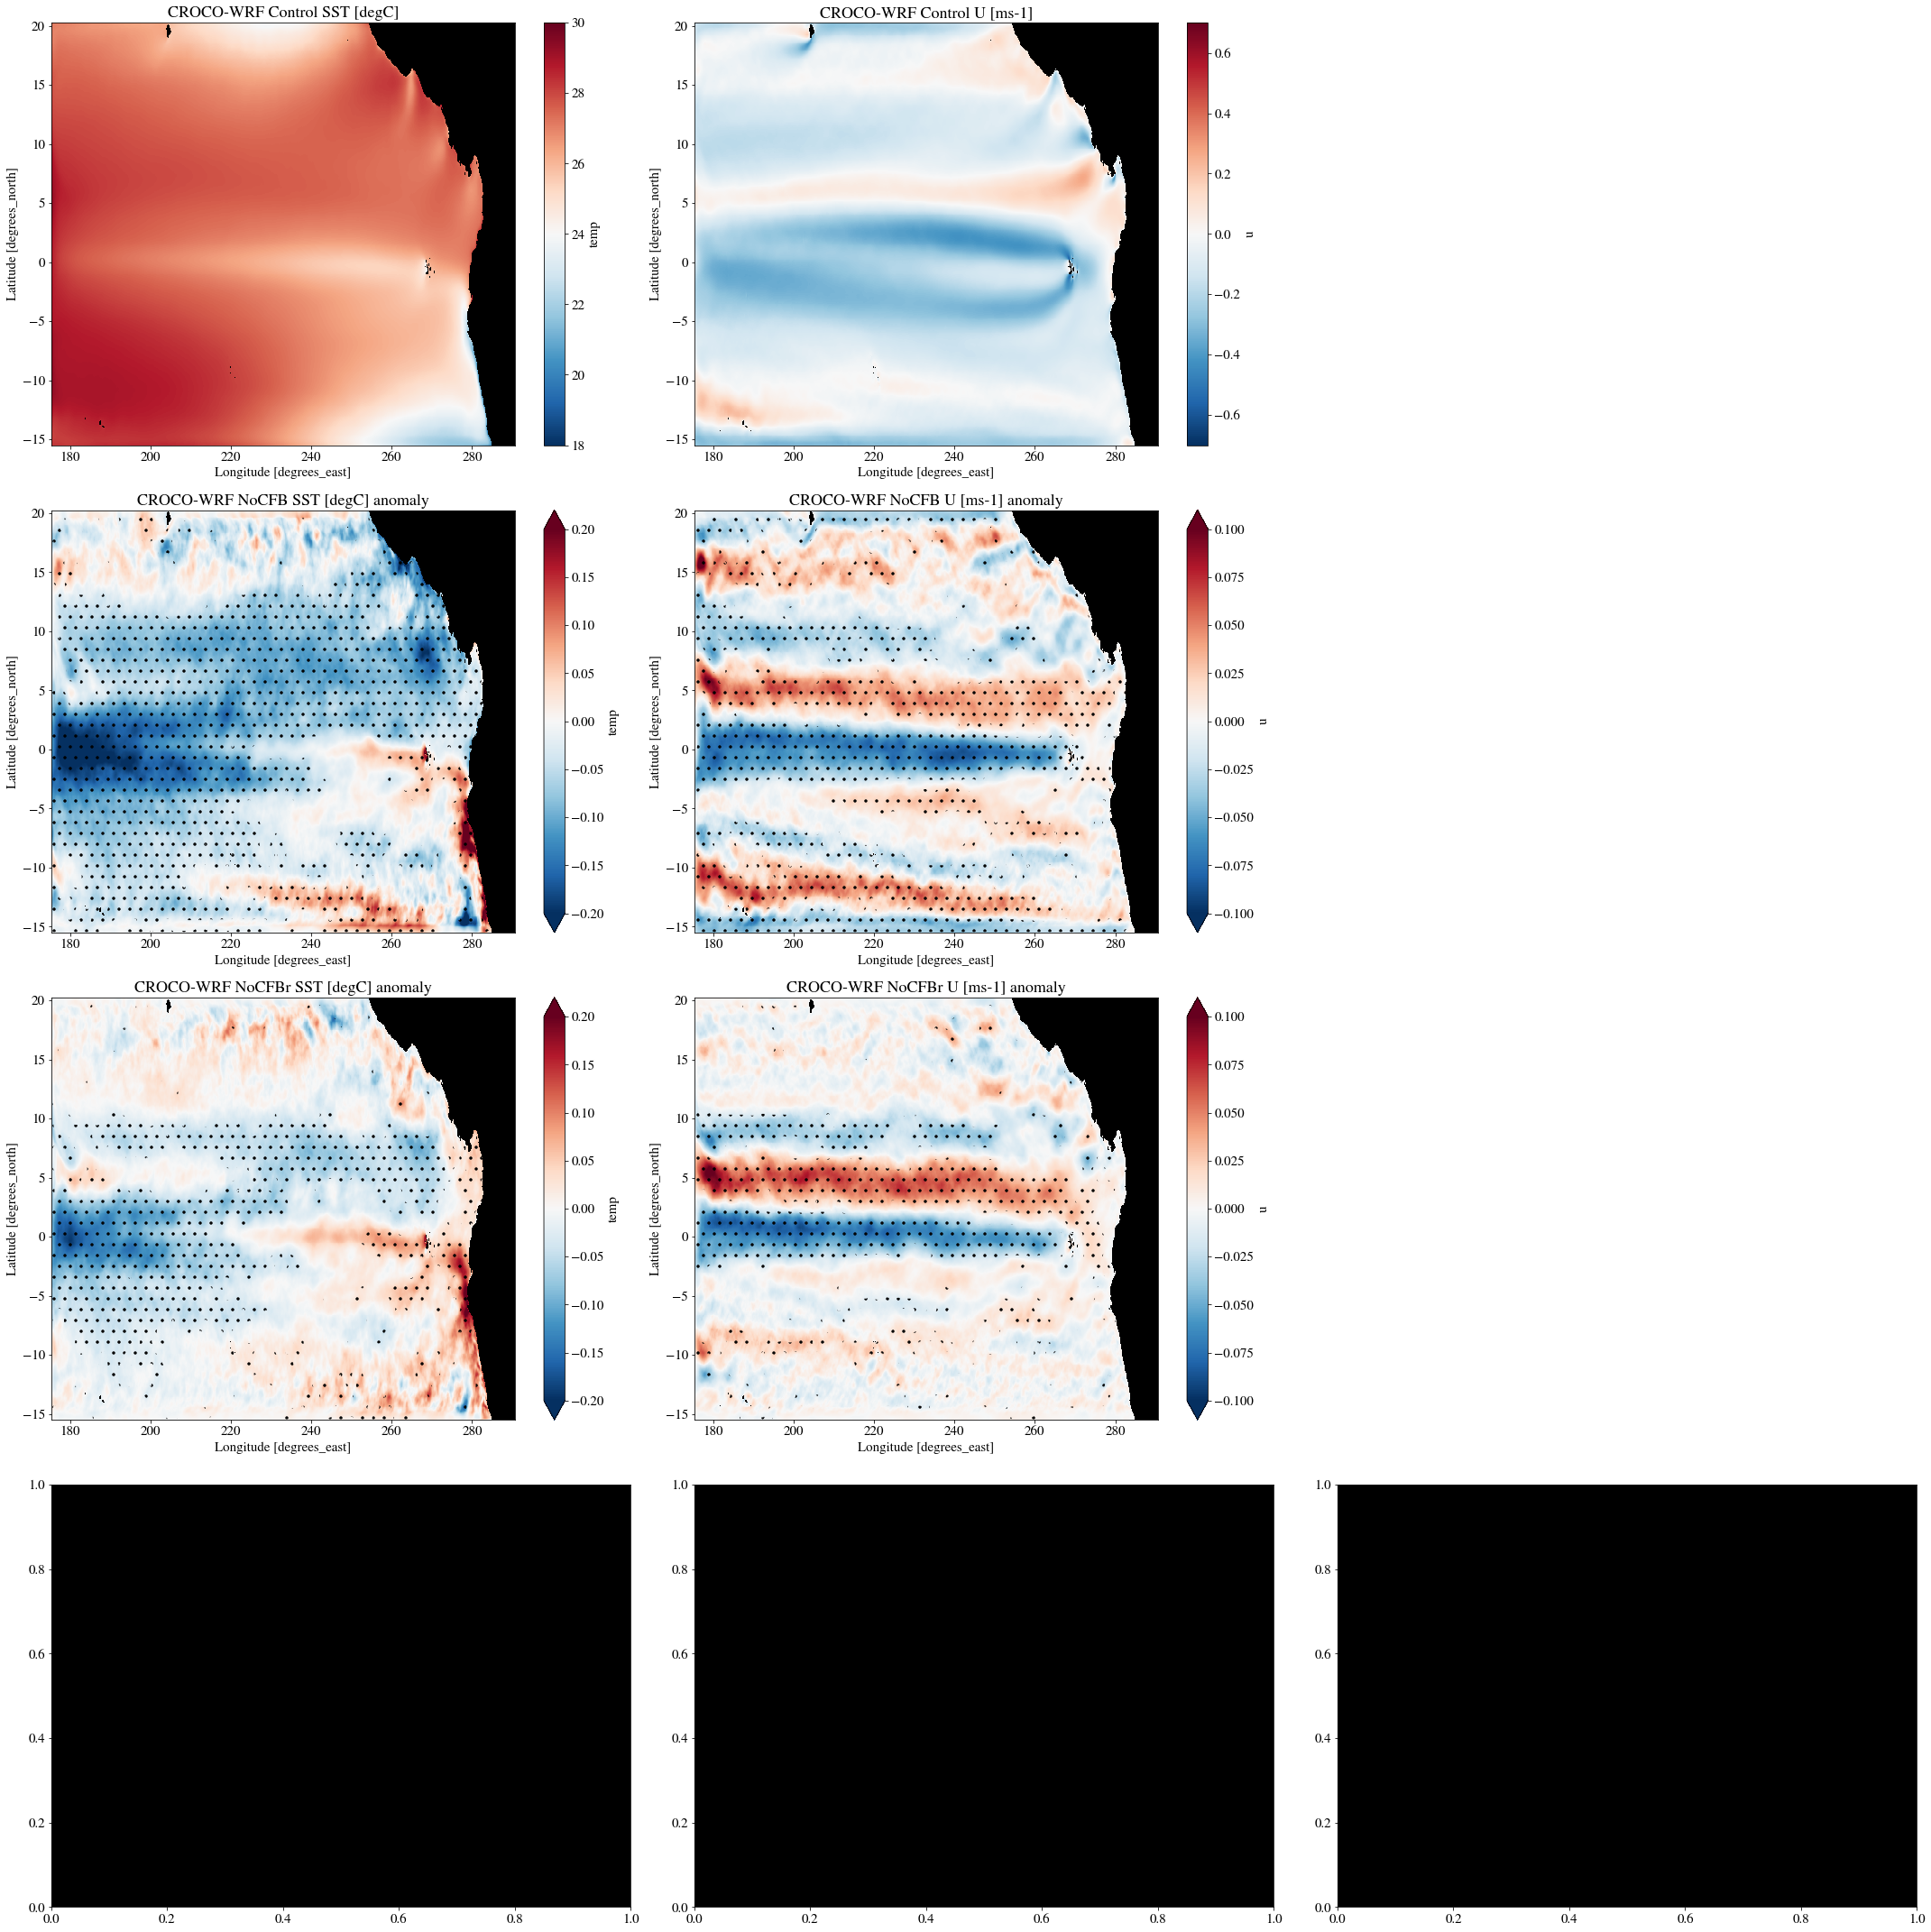

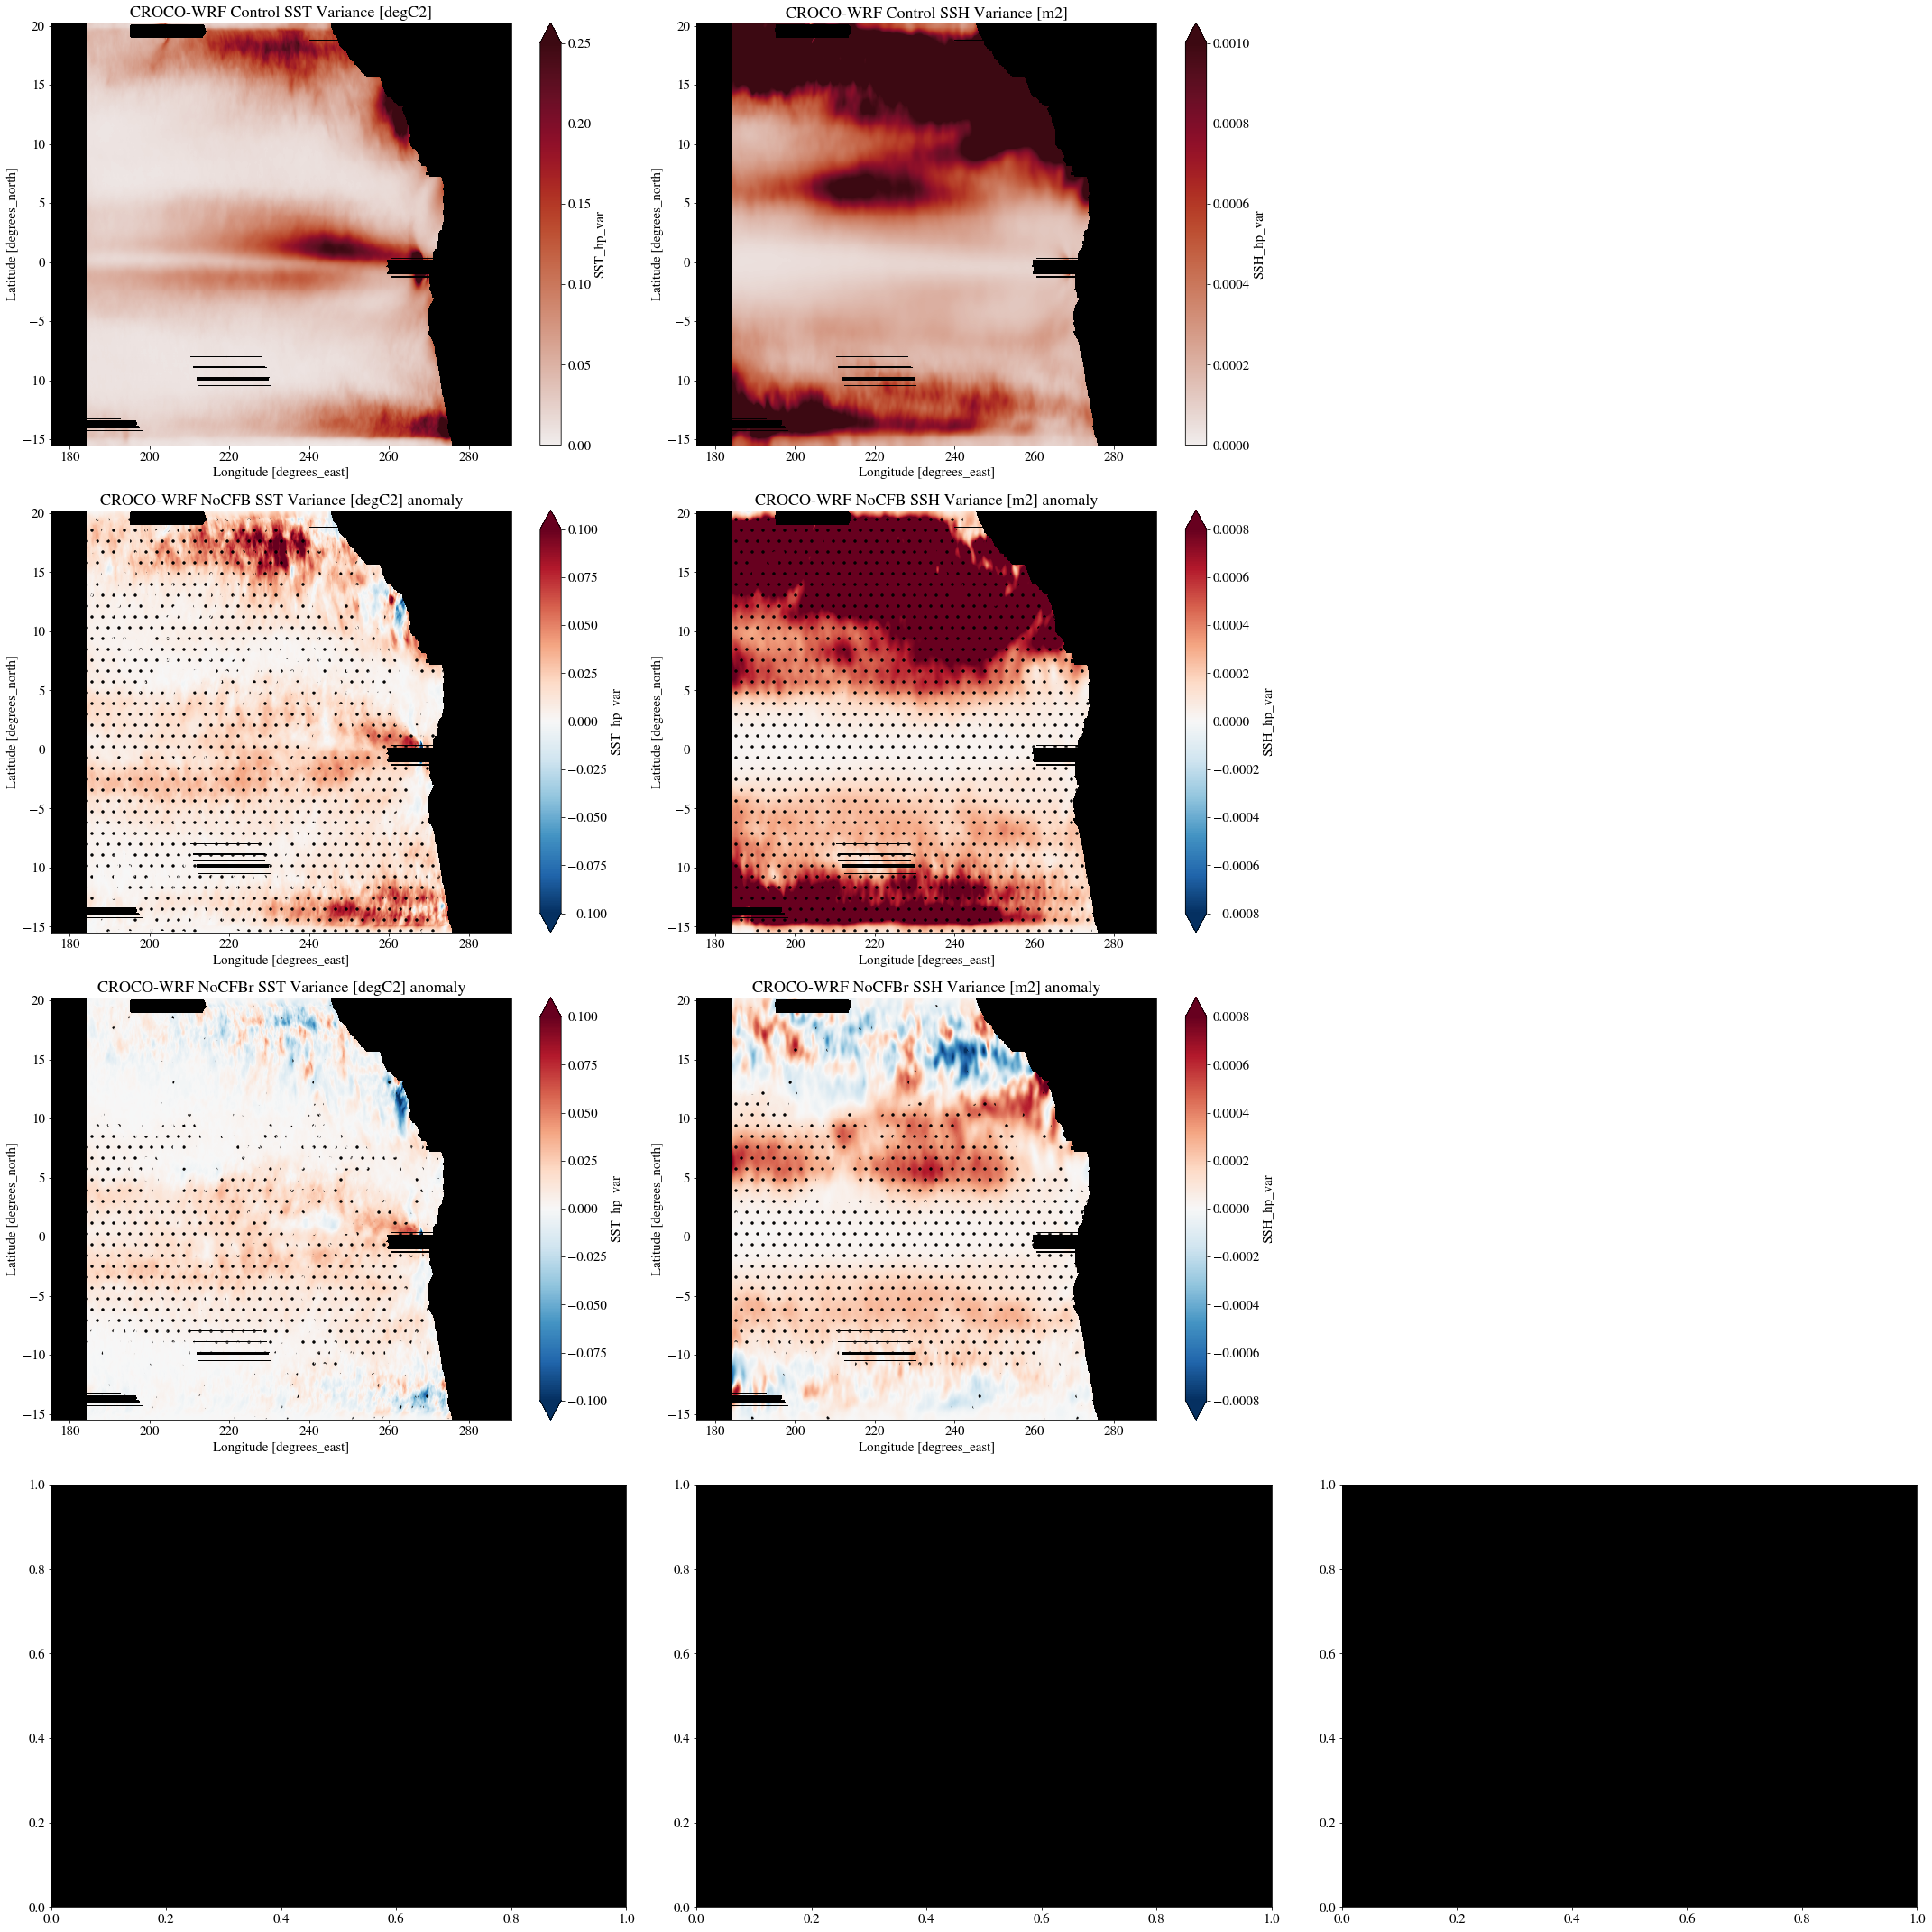

In [18]:
hatch_sig = True
#keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB','CROCO-WRF NoCFBr']
keys = ['CROCO-WRF NoCFB','CROCO-WRF NoCFBr']
varla = [
    # # Wind:
    # {'varl':[{'var':WXv,'label':'Zonal high-pass wind variance [m2s-2]','mclim':[0.,1.],'aclim':[-1.e-1,1.e-1],'cmap':cm.cm.amp},
    #          {'var':WYv,'label':'Meridional high-pass wind variance [m2s-2]','mclim':[0.,1.],'aclim':[-1.e-1,1.e-1],'cmap':cm.cm.amp}
    #         ],
    # 'fname':'Mean_State_Variability_Changes/CROCO-WRF_hpWindVar.png'},    
    # # Stress:
    # {'varl':[{'var':SXv,'label':'Zonal high-pass stress variance [N2m-4]','mclim':[0.,5.e-4],'aclim':[-4.e-5,4.e-5],'cmap':cm.cm.amp},
    #          {'var':SYv,'label':'Meridional high-pass stress variance [N2m-4]','mclim':[0.,5.e-4],'aclim':[-4.e-5,4.e-5],'cmap':cm.cm.amp}
    #         ],
    # 'fname':'Mean_State_Variability_Changes/CROCO-WRF_hpStressVar.png'},    
    # # Wdiv, Wcur:
    # {'varl':[{'var':Wdivv,'label':'High-pass wind divergence variance [s-2]','mclim':[0.,1.e-9],'aclim':[-2.e-11,2.e-11],'cmap':cm.cm.amp},
    #    {'var':Wcurv,'label':'High-pass wind curl variance [s-2]','mclim':[0.,1.e-9],'aclim':[-2.e-11,2.e-11],'cmap':cm.cm.amp}
    #        ],
    # 'fname':'Mean_State_Variability_Changes/CROCO-WRF_hpWindCurlDiv.png'},
    # # Sdiv, Scur:
    # {'varl':[{'var':Sdivv,'label':'High-pass stress divergence variance [s-2]','mclim':[0.,0.04e-12],'aclim':[-.5e-14,.5e-14],'cmap':cm.cm.amp},
    #          {'var':Scurv,'label':'High-pass stress curl variance [s-2]','mclim':[0.,0.04e-12],'aclim':[-.5e-14,.5e-14],'cmap':cm.cm.amp}
    #          ],
    # 'fname':'Mean_State_Variability_Changes/CROCO-WRF_hpStressCurlDiv.png'}, 
    
    #  # surface heat flux variance quantities:
    # {'varl':[{'var':Qv,'label':'High-pass surface heat flux variance [W2m-4]','mclim':[0.,1.e3],'aclim':[-.5e1,.5e1],'cmap':cm.cm.amp},
    #          {'var':Ge,'label':'Eddy APE generation [Wm-2]','mclim':[0.,5.e-3],'aclim':[-.5e-5,.5e-5],'cmap':cm.cm.amp},
    #          {'var':Gm,'label':'Mean APE generation [Wm-2]','mclim':[0.,5.e5],'aclim':[-5,5],'cmap':cm.cm.amp}
    #          ],
    # 'fname':''}, 

#     # V, TAUs:
#     {'varl':[{'var':WRFTAUM,'label':'Wind Stress Magnitude [Nm-2]','mclim':[0.,0.2],'aclim':[-0.006,0.006],'cmap':cm.cm.amp},
#        {'var':WRFTAUX,'label':'zonal wind stress [Nm-2]','mclim':[-0.15,0.15],'aclim':[-0.006,0.006],'cmap':'RdBu_r'},
#        {'var':WRFTAUY,'label':'meridional wind stress [Nm-2]','mclim':[-0.15,0.15],'aclim':[-0.006,0.006],'cmap':'RdBu_r'}
# #       {'var':SWFLX,'label':'surface volume flux [cms-1]','mclim':[-1.5,1.5],'aclim':[-0.12,0.12],'cmap':'RdBu_r'},
#             ],
#     'fname':'Mean_State_Variability_Changes/CROCO-WRF_TAUM_TAUX_TAUY.png'},
    # SST, SSH, U:
    {'varl':[{'var':SST,'label':'SST [degC]','mclim':[18.,30.],'aclim':[-0.2,0.2],'cmap':'RdBu_r'},
#       {'var':SSH,'label':'SSH [m]','mclim':[-0.4,0.4],'aclim':[-0.04,0.04],'cmap':'RdBu_r'},
#       {'var':SSS,'label':'SSS [psu]','mclim':[33.,36.],'aclim':[-0.25,0.25],'cmap':'RdBu_r'},
       {'var':U,'label':'U [ms-1]','mclim':[-0.7,0.7],'aclim':[-0.1,0.1],'cmap':'RdBu_r'}
            ],
    'fname':'Mean_State_Variability_Changes/CROCO-WRF_SST_SSH_U_NoCFBNoCFBr.png'},
#     # V, TAUs:
#     {'varl':[{'var':V,'label':'V [ms-1]','mclim':[-0.3,0.3],'aclim':[-0.05,0.05],'cmap':'RdBu_r'},
#        {'var':TAUU,'label':'zonal wind stress [Nm-2]','mclim':[-0.15,0.15],'aclim':[-0.006,0.006],'cmap':'RdBu_r'},
#        {'var':TAUV,'label':'meridional wind stress [Nm-2]','mclim':[-0.15,0.15],'aclim':[-0.006,0.006],'cmap':'RdBu_r'}
# #       {'var':SWFLX,'label':'surface volume flux [cms-1]','mclim':[-1.5,1.5],'aclim':[-0.12,0.12],'cmap':'RdBu_r'},
#             ],
#     'fname':'Mean_State/CROCO-WRF_V_TAU.png'},
    # # SHFLX,RAIN,WSPD:
    # {'varl':[{'var':SHFLX,'label':'surface heat flux [Wm-2]','mclim':[-200.,200.],'aclim':[-12.,12.],'cmap':cm.cm.amp},
    #    {'var':RAIN,'label':'total precipitation [mm/day]','mclim':[0.,15.],'aclim':[-1.,1.],'cmap':cm.cm.amp},
    #    {'var':WSPD,'label':'surface wind speed [ms-1]','mclim':[0.,10.],'aclim':[-0.25,0.25],'cmap':cm.cm.amp},
    #         ],
    # 'fname':'Mean_State/CROCO-WRF_SHFLX_RAIN_WSPD_NoCFBNoCFBr.png'},
    # SSTv, SSHv, EKE
    {'varl':[{'var':SSTv,'label':'SST Variance [degC2]','mclim':[0.,0.25],'aclim':[-0.1,0.1],'cmap':cm.cm.amp},
       {'var':SSHv,'label':'SSH Variance [m2]','mclim':[0.,0.001],'aclim':[-0.0008,0.0008],'cmap':cm.cm.amp},
#       {'var':EKE,'label':'EKE [m2s-2]','mclim':[0.,1.e-1],'aclim':[-.5e-1,.5e-1],'cmap':cm.cm.amp},
            ],
    'fname':'Mean_State_Variability_Changes/CROCO-WRF_SSTv_SSHv_EKE_NoCFBNoCFBr.png'},
#     # MKE, EWW, MWW:
#     {'varl':[{'var':MKE,'label':'MKE [m2s-2]','mclim':[0.,0.25],'aclim':[-0.05,0.05],'cmap':cm.cm.amp},
#        {'var':EWW,'label':'Eddy Wind-Work [Nm-1s-1]','mclim':[-1.e-3,1.e-3],'aclim':[-0.001,0.001],'cmap':'RdBu_r'},
#        {'var':MWW,'label':'Mean Wind-Work [Nm-1s-1]','mclim':[-.3e-1,.3e-1],'aclim':[-1.e-2,1.e-2],'cmap':'RdBu_r'},
#             ],
#     'fname':'Mean_State/CROCO-WRF_MKE_EWW_MWW.png'},
#     {'varl':[{'var':VSST,'label':'V*SST [degCms-1]','mclim':[-0.05,0.05],'aclim':[-0.02,0.02],'cmap':'RdBu_r'},
#          {'var':VSST,'label':'V*SST [degCms-1]','mclim':[-0.05,0.05],'aclim':[-0.02,0.02],'cmap':'RdBu_r'},
#          {'var':VSST,'label':'V*SST [degCms-1]','mclim':[-0.05,0.05],'aclim':[-0.02,0.02],'cmap':'RdBu_r'},
#             ],
#     'fname':'Mean_State/CROCO-WRF_VSST.png'},
]

for j,vard in enumerate(varla):
    varl = vard['varl']
    fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(30,30),facecolor='w')
    axs = axes.flatten()
    for i,var in enumerate(varl):
        var['var'][cont].plot(ax=axes[0][i],vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'])
        axes[0][i].set_title(cont + ' ' + var['label'])

    for i, key in enumerate(keys):
        for j, var in enumerate(varl):
            (var['var'][key]-var['var'][cont]).plot(ax=axes[i+1][j],vmin=var['aclim'][0],vmax=var['aclim'][1],cmap='RdBu_r',extend='both')
            if hatch_sig:  var['var'][key+'-s'].plot.contourf(ax=axes[i+1][j],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
            axes[i+1][j].set_title(key + ' ' + var['label'] + ' anomaly')

    for axs in axes.flatten():
        axs.set_facecolor('k')
    
    if (len(varl)==2):
        axes[0][2].axis('off')
        for i, key in enumerate(keys):
            axes[i+1][2].axis('off')
    plt.tight_layout()
    plt.savefig(vard['fname'],dpi=1001)

In [ ]:
# SST, RAIN, SHFLX from Smooth-SST only:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(30,15),facecolor='w')
hatch_sig = True
keys = ['CROCO-WRF Smooth-SST']#,'CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
varl = [{'var':SST,'label':'SST [degC]','mclim':[18.,30.],'aclim':[-0.2,0.2],'cmap':'RdBu_r'},
       {'var':RAIN,'label':'total precipitation [mm/day]','mclim':[0.,15.],'aclim':[-1.,1.],'cmap':cm.cm.amp},
       {'var':SHFLX,'label':'surface heat flux [Wm-2]','mclim':[-200.,200.],'aclim':[-12.,12.],'cmap':cm.cm.amp}]

axs = axes.flatten()
for i,var in enumerate(varl):
    var['var'][cont].plot(ax=axes[0][i],vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'])
    axes[0][i].set_title(cont + ' ' + var['label'])

for i, key in enumerate(keys):
    for j, var in enumerate(varl):
        (var['var'][key]-var['var'][cont]).plot(ax=axes[i+1][j],vmin=var['aclim'][0],vmax=var['aclim'][1],cmap='RdBu_r',extend='both')
        if hatch_sig:  var['var'][key+'-s'].plot.contourf(ax=axes[i+1][j],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
        axes[i+1][j].set_title(key + ' ' + var['label'] + ' anomaly')

for axs in axes.flatten():
    axs.set_facecolor('k')
plt.tight_layout()
plt.savefig('Mean_State/CROCO-WRF_SST_RAIN_SHFLX.png',dpi=100)

## Surface mean state and variance differences (latitude profiles):

In [ ]:
#LONS = 200., 250.
LONS = 210., 260.

# keys = ['CROCO-WRF Control',
#         'CROCO-WRF Control-E1','CROCO-WRF Control-E2','CROCO-WRF Control-E3','CROCO-WRF Control-E4','CROCO-WRF Control-E5',
#         'CROCO-WRF NoTFB',
#         'CROCO-WRF NoTFB-E1','CROCO-WRF NoTFB-E2','CROCO-WRF NoTFB-E3','CROCO-WRF NoTFB-E4','CROCO-WRF NoTFB-E5',
#         'CROCO-WRF NoMesoCFB',
#         'CROCO-WRF NoMesoCFB-E1','CROCO-WRF NoMesoCFB-E2','CROCO-WRF NoMesoCFB-E3','CROCO-WRF NoMesoCFB-E4','CROCO-WRF NoMesoCFB-E5',
#         'CROCO-WRF NoCFB',
#         'CROCO-WRF NoCFB-E1','CROCO-WRF NoCFB-E2','CROCO-WRF NoCFB-E3','CROCO-WRF NoCFB-E4','CROCO-WRF NoCFB-E5']

keys = expdict.keys() + ['CROCO-WRF Control','CROCO-WRF NoTFB','CROCO-WRF NoCFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFBr']
SSTll = {};SWFLXll={};SSHll = {};Ull={};Vll={};SSSll={};TAUUll={};TAUVll={};SHFLXll={};
RAINll={};WSPDll={}; WRFTAUMll = {}; WRFTAUXll = {}; WRFTAUYll = {};
SSTvll = {};SSHvll = {};EKEll={};MKEll={};EWWll={};MWWll={};VSSTll={}
Wdivvll = {}; Wcurvll = {}; Sdivvll = {}; Scurvll = {};WXvll = {}; WYvll = {};SXvll = {}; SYvll = {};WRFSSTvll = {};
for key in keys:
    print(key)
    # SSTll[key] = SST[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # SSHll[key] = SSH[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # SWFLXll[key] = SWFLX[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # Ull[key] = U[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # Vll[key] = V[key].sel(x_v=slice(LONS[0],LONS[1])).mean('x_v').load()
    # SSSll[key] = SSS[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # TAUUll[key] = TAUU[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # TAUVll[key] = TAUV[key].sel(x_v=slice(LONS[0],LONS[1])).mean('x_v').load()
    # SHFLXll[key] = SHFLX[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    
    # RAINll[key] = RAIN[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # WSPDll[key] = WSPD[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # WRFTAUMll[key] = WRFTAUM[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # WRFTAUXll[key] = WRFTAUX[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # WRFTAUYll[key] = WRFTAUY[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # Wdivvll[key] = Wdivv[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # Wcurvll[key] = Wcurv[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # Sdivvll[key] = Sdivv[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # Scurvll[key] = Scurv[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    # WXvll[key] = WXv[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # WYvll[key] = WYv[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # SXvll[key] = SXv[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    # SYvll[key] = SYv[key].sel(x=slice(LONS[0],LONS[1])).mean('x').load()
    
    # SSTvll[key] = SSTv[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # SSHvll[key] = SSHv[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # EKEll[key] = EKE[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # MKEll[key] = MKE[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # EWWll[key] = EWW[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # MWWll[key] = MWW[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    # VSSTll[key] = VSST[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    
    Qvll[key] = Qv[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    Gevll[key] = Gev[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    Gmvll[key] = Gmv[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()

In [ ]:
# Calculate standard error ranges for ensembles:
zScore = 1.96 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)

lst = [SSTll,SWFLXll,RAINll,SSHll,SSSll,SHFLXll,TAUUll,TAUVll,Ull,Vll,SHFLXll,WSPDll,SSTvll,SSHvll,EKEll,MKEll,EWWll,MWWll,VSSTll]
lst = [WRFTAUMll,WRFTAUXll,WRFTAUYll]
lst = [Wdivvll,Wcurvll,Sdivvll,Scurvll,WXvll,WYvll,SXvll,SYvll]
lst = [Qvll,Gell,Gmll]
runs = ['Control','NoTFB','NoMesoCFB','NoCFB','NoCFBr']

for obj in lst:
    
    for run in runs:
        # Calculate standard error:
        obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            obj['CROCO-WRF ' + run + '-s'] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
        obj['CROCO-WRF ' + run + '-s'] = np.sqrt(obj['CROCO-WRF ' + run + '-s']/eL)/np.sqrt(eL)

In [ ]:
# Percentage change in latitude-bounded region:
LATS = -5., 5.
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
names = ['SST Variance  ','SSH Variance  ','EKE           ','MKE           ','Eddy Wind Work','Mean Wind Work','V*SST         ']
perc = {}
for key in keys:
    print(key)
    perc[key] = []
    for i,obj in enumerate([SSTvll,SSHvll,EKEll,MKEll,EWWll,MWWll,VSSTll]):
        cont = obj['CROCO-WRF Control'].sel(y_rho=slice(LATS[0],LATS[1])).mean('y_rho')
        pert = obj[key].sel(y_rho=slice(LATS[0],LATS[1])).mean('y_rho')
        obj[key]['pc']= 100.*(pert-cont)/cont
        print(names[i] + ' percent - change = %01d ' % (obj[key]['pc']))
    print('\n')

In [ ]:
# Latitude line plots (all ensembles):
fig, axes = plt.subplots(nrows=4,ncols=4,figsize=(20,25),facecolor='w')

axs = axes.flatten()

fix_xlims = True
cont = 'CROCO-WRF Control'

runs = ['Control','NoTFB','NoMesoCFB','NoCFB']
cols = ['0.65','C0','C1','C2']
labels = ['Control','NoTFB','NoMesoCFB','NoCFB']
varsd = [
#     # Mean's absolutes:
#          {'var':SSTll,'label':'SST [degC]','axlim':[-0.11,0.1],'mxlim':[25.8,27.8],'yco':'y_rho','anom':False,'add_p':False},#[25.8,27.75]
#          {'var':SSHll,'label':'SSH [m]','axlim':[-0.02,0.011],'mxlim':[-0.12,-0.01],'yco':'y_rho','anom':False,'add_p':False},
#          {'var':Ull,'label':'Zonal Surface Velocity [ms-1]','axlim':[-0.08,0.04],'mxlim':[-0.42,0.12],'yco':'y_u','anom':False,'add_p':False},
#          {'var':RAINll,'label':'Total Precipitation [mm/day]','axlim':[-0.75,0.75],'mxlim':[-10.,0.],'yco':'y','anom':False,'add_p':False},
#          {'var':WSPDll,'label':'Surface wind speed [ms-1]','axlim':[-0.27,0.1],'mxlim':[5.2,6.5],'yco':'y','anom':False,'add_p':False},
#          {'var':TAUUll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y_u','anom':False,'add_p':False},
#     # Mean's anomalies:
#          {'var':SSTll,'label':'SST [degC]','axlim':[-0.11,0.1],'mxlim':[25.8,29.],'yco':'y_rho','anom':True,'add_p':False},#[25.8,27.75]
#          {'var':SSHll,'label':'SSH [m]','axlim':[-0.02,0.011],'mxlim':[-0.12,-0.01],'yco':'y_rho','anom':True,'add_p':False},
#          {'var':Ull,'label':'Zonal Surface Velocity [ms-1]','axlim':[-0.08,0.04],'mxlim':[-0.42,0.12],'yco':'y_u','anom':True,'add_p':False},
#          {'var':RAINll,'label':'Total Precipitation [mm/day]','axlim':[-0.75,0.75],'mxlim':[-15.,0.],'yco':'y','anom':True,'add_p':False},
#          {'var':WSPDll,'label':'Surface wind speed [ms-1]','axlim':[-0.27,0.1],'mxlim':[5.2,6.5],'yco':'y','anom':True,'add_p':False},
#          {'var':TAUUll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y_u','anom':True,'add_p':False},
#     # Variance absolutes:
#         {'var':SSTvll,'label':'SST Variance [degC2]','axlim':[-0.03,0.2],'mxlim':[0.,0.32],'yco':'y_rho','anom':False,'add_p':True},
#         {'var':SSHvll,'label':'SSH Variance [m2]','axlim':[-0.001,0.001],'mxlim':[0.,0.002],'yco':'y_rho','anom':False,'add_p':True},
#         {'var':EKEll,'label':'EKE [m2s-2]','axlim':[-0.005,0.03],'mxlim':[0.,0.09],'yco':'y_rho','anom':False,'add_p':True},
#         {'var':MKEll,'label':'MKE [m2s-2]','axlim':[-0.02,0.08],'mxlim':[0.,0.4],'yco':'y_rho','anom':False,'add_p':True},
#         {'var':EWWll,'label':'Eddy Wind Work [Nm-1s-1]','axlim':[-.4e-3,.5e-3],'mxlim':[-7.e-4,7.e-4],'yco':'y_rho','anom':False,'add_p':True},
#         {'var':MWWll,'label':'Mean Wind Work [Nm-1s-1]','axlim':[-.4e-3,.5e-3],'mxlim':[0.,0.021],'yco':'y_rho','anom':False,'add_p':True},   
# # Other:
#         {'var':TAUUll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y_u','anom':False,'add_p':False},
#         {'var':TAUVll,'label':'Meridional Wind Stress [Nm-2]','axlim':[-2.5e-3,1.5e-3],'mxlim':[-20.e-3,25.e-3],'yco':'y_v','anom':False,'add_p':False},
#         {'var':SWFLXll,'label':'Surface net volume flux [mm/day]','axlim':[-0.75,0.75],'mxlim':[-10.,10.],'yco':'y_rho','anom':True,'add_p':False},
# #         {'var':SSSll,'label':'SSS [psu]','axlim':[-0.05,0.15],'mxlim':[34.25,35.5]},
# #        {'var':SHFLXll,'label':'Surface net heat flux [Wm-2]','axlim':[-4.,4.],'mxlim':[0.,120.],'yco':'y_rho','anom':False,'add_p':False},
#         {'var':VSSTll,'label':'V*SST [degCms-1]','axlim':[-0.05,0.05],'mxlim':[-0.045,0.03],'yco':'y_rho','anom':False,'add_p':True},   
    # # WRF Stresses:
    #     {'var':WRFTAUMll,'label':'Wind Stress Magnitude [Nm-2]','axlim':[-0.006,0.006],'mxlim':[0.035,0.08],'yco':'y','anom':False,'add_p':False},
    #     {'var':WRFTAUXll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y','anom':False,'add_p':False},
    #     {'var':WRFTAUYll,'label':'Meridional Wind Stress [Nm-2]','axlim':[-2.5e-3,1.5e-3],'mxlim':[-20.e-3,25.e-3],'yco':'y','anom':False,'add_p':False},
    #     {'var':WRFTAUMll,'label':'Wind Stress Magnitude [Nm-2]','axlim':[-0.002,0.002],'mxlim':[0.,0.08],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUXll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUYll,'label':'Meridional Wind Stress [Nm-2]','axlim':[-2.5e-3,1.5e-3],'mxlim':[-20.e-3,25.e-3],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUMll,'label':'Wind Stress Magnitude [Nm-2]','axlim':[-0.002,0.002],'mxlim':[0.,0.08],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUXll,'label':'Zonal Wind Stress [Nm-2]','axlim':[-0.002,0.002],'mxlim':[-60.e-3,-30.e-3],'yco':'y','anom':True,'add_p':False},
    #     {'var':WRFTAUYll,'label':'Meridional Wind Stress [Nm-2]','axlim':[-2.5e-3,1.5e-3],'mxlim':[-20.e-3,25.e-3],'yco':'y','anom':True,'add_p':False},
    # # High-pass wind/stress variances:
    #     {'var':WXvll,'label':'Zonal wind variance [m2s-2]','xlim':[0.,.75],'yco':'y','anom':False,'add_p':False},
    #     {'var':WYvll,'label':'Meridional wind variance [m2s-2]','xlim':[0.,.75],'yco':'y','anom':False,'add_p':False},
    #     {'var':SXvll,'label':'Zonal stress variance [N2m-4]','xlim':[0.,2.e-4],'yco':'y','anom':False,'add_p':False},
    #     {'var':SYvll,'label':'Meridional stress variance [N2m-4]','xlim':[0.,2.e-4],'yco':'y','anom':False,'add_p':False},
    #     {'var':WXvll,'label':'Zonal wind variance [m2s-2]','xlim':[-1.e-1,1.e-1],'yco':'y','anom':True,'add_p':False},
    #     {'var':WYvll,'label':'Meridional wind variance [m2s-2]','xlim':[-1.e-1,1.e-1],'yco':'y','anom':True,'add_p':False},
    #     {'var':SXvll,'label':'Zonal stress variance [N2m-4]','xlim':[-.4e-4,.4e-4],'yco':'y','anom':True,'add_p':False},
    #     {'var':SYvll,'label':'Meridional stress variance [N2m-4]','xlim':[-.4e-4,.4e-4],'yco':'y','anom':True,'add_p':False},
    #     {'var':Wdivvll,'label':'Wind Divergence Variance [s-2]','xlim':[0.,0.2e-9],'yco':'y_v','anom':False,'add_p':False},
    #     {'var':Wcurvll,'label':'Wind Curl Variance [s-2]','xlim':[0.,0.2e-9],'yco':'y_v','anom':False,'add_p':False},
    #     {'var':Sdivvll,'label':'Stress Divergence Variance [s-2]','xlim':[0.,0.04e-12],'yco':'y_v','anom':False,'add_p':False},
    #     {'var':Scurvll,'label':'Stress Curl Variance [s-2]','xlim':[0.,0.04e-12],'yco':'y_v','anom':False,'add_p':False},
    #     {'var':Wdivvll,'label':'Wind Divergence Variance [s-2]','xlim':[-2.e-11,2.e-11],'yco':'y_v','anom':True,'add_p':False},
    #     {'var':Wcurvll,'label':'Wind Curl Variance [s-2]','xlim':[-1.e-11,1.e-11],'yco':'y_v','anom':True,'add_p':False},
    #     {'var':Sdivvll,'label':'Stress Divergence Variance [s-2]','xlim':[-.5e-14,.5e-14],'yco':'y_v','anom':True,'add_p':False},
    #     {'var':Scurvll,'label':'Stress Curl Variance [s-2]','xlim':[-.5e-14,.5e-14],'yco':'y_v','anom':True,'add_p':False},
    # High-pass surface heat flux variance quantities:
        {'var':WXvll,'label':'Zonal wind variance [m2s-2]','xlim':[0.,.75],'yco':'y','anom':False,'add_p':False},
        {'var':WYvll,'label':'Meridional wind variance [m2s-2]','xlim':[0.,.75],'yco':'y','anom':False,'add_p':False},
        {'var':SXvll,'label':'Zonal stress variance [N2m-4]','xlim':[0.,2.e-4],'yco':'y','anom':False,'add_p':False},
        ]

for i,varss in enumerate(varsd):
    for j,run in enumerate(runs):
        for k in range(eL):
            ckey = 'CROCO-WRF ' + run
            key = ckey + '-E%01d' % (k+1)
            if varss['anom']:
                var = varss['var'][key]-varss['var'][cont]
                varc = varss['var'][ckey]-varss['var'][cont]
            else:
                var = varss['var'][key]
                varc = varss['var'][ckey]
#            var.plot(y=varss['yco'],ax=axs[i],color=cols[j],linewidth=0.5,alpha=0.75)
        varc.plot(y=varss['yco'],ax=axs[i],label=labels[j],color=cols[j],linewidth=3.)
        std = varss['var'][ckey + '-s']
        axs[i].fill_betweenx(std[varss['yco']],-zScore*std+varc,zScore*std+varc,color=cols[j],alpha=0.5)
    lab = varss['label']
    if varss['anom']: lab+= ' anomaly'        
    axs[i].set_xlabel(lab)
    if fix_xlims:
        axs[i].set_xlim(varss['xlim'])
    if varss['add_p']:
        for j,run in enumerate(runs[1:]):
            ckey = 'CROCO-WRF ' + run
            xlims = axs[i].get_xlim()
            axs[i].text(xlims[0]+0.85*(xlims[1]-xlims[0]),-3.8+j*0.75,'%01d%%' % varss['var'][ckey]['pc'],color=cols[j+1])


for ax in axs:
    ax.grid()
    ax.set_ylabel('')
    ax.set_yticklabels({})
    ax.set_title('')
for ax in [axes[i][0] for i in range(np.shape(axes)[0])]:
    ax.set_ylabel('Latitude ($^\circ$N)')
    ax.set_yticklabels(np.arange(-10.,20.,2.))
for ax in axs:
    ax.set_yticks(np.arange(-10.,20.,2.))
    ax.set_ylim([-5.,12.])

axs[1].legend(loc='upper left')
axs[7].legend(loc='upper left')
axs[12].legend(loc='upper right')

plt.tight_layout()
#plt.savefig('Mean_State_Variability_Changes/Latitude_Profile_210to260_CROCO-WRF_hpWindStressDivCur.png',dpi=100)

## Equatorial slice mean state and variance differences (Depth-longitude and vertical profile):

In [ ]:
# Mean state variables:
T = {};U = {};S = {};Z={};

lats = -1.,1.

# Restrict seasonally:
def is_season(month):
    return (month >= 1) & (month <= 12) # Full year
#    return (month >= 7) & (month <= 11)
#    return (month <= 2) | (month >= 12)  # DJF
#    return (month >= 7)                  # TIW season

keys = expdict.keys()
for key in keys:
    print(key)
    T[key] = data[key]['mon'].temp.sel(y_rho=slice(lats[0],lats[1])).mean('y_rho').sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    S[key] = data[key]['mon'].salt.sel(y_rho=slice(lats[0],lats[1])).mean('y_rho').sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    U[key] = data[key]['mon'].u.sel(y_u=slice(lats[0],lats[1])).mean('y_u').sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()

Z = data['CROCO-WRF Control-E3']['mon'].z_rho.sel(y_rho=slice(lats[0],lats[1])).mean('y_rho').load()

In [ ]:
# Calculate ensembles:
lst = [T,S,U]
runs = ['Control','NoTFB','NoMesoCFB','NoCFB']
for obj in lst:
    for run in runs:
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run + '-E1'].copy()
        for ei in range(eL-1):
            obj['CROCO-WRF ' + run] += obj['CROCO-WRF ' + run + '-E%01d' % (ei+2)]
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run]/eL
cont = 'CROCO-WRF Control'

In [ ]:
# Calculate significance levels for perturbations:
typ = 'Welch'
### Option 1: Z score on Control ensemble:
if (typ == 'ConZ'):
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviation:
        std = np.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            std += (obj['CROCO-WRF Control-E%01d' % (e+1)]-obj['CROCO-WRF Control'])**2.
        std = np.sqrt(std/eL)

        for key in keys:
            obj[key + '-s'] = xr.zeros_like(obj[key])
            obj[key + '-s'].values = np.where(abs(obj[key].values-obj['CROCO-WRF Control'])>(zScore*std),1.,0.)

### Option 2: Instead use outside range of ensemble members:
elif (typ == 'ConR'):    # 
    yL, xL = np.shape(obj['CROCO-WRF Control-E1'].values)
    tmp = np.zeros((yL,xL,eL))
    for e in range(eL):
        tmp[:,:,e] = obj[pert].values - obj['CROCO-WRF Control-E%01d' % (e+1)].values

    obj[key + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
    obj[key + '-s'].values = np.logical_or(np.all(tmp>0.,axis=2),np.all(tmp<0.,axis=2))
    
### Option 3: Welch's t-test (https://en.wikipedia.org/wiki/Welch%27s_t-test) on two distributions:
elif (typ == 'Welch'):
    critp = 0.05  # critical p-value
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviations:
        std = {}
        for run in runs:
            std[run] = np.zeros_like(obj['CROCO-WRF Control-E1'])
            for e in range(eL):
                std[run] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
            std[run] = np.sqrt(std[run]/(eL-1)) # Corrected sample standard deviation https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation

        # Calculate t and degrees-of-freedom:
        t = {}
        nu = {}
        for run in runs:
            s1 = std[run]/np.sqrt(eL)
            s2 = std['Control']/np.sqrt(eL)
            sd = np.sqrt(s1**2.+s2**2.)
            t[run] = (obj['CROCO-WRF ' + run] - obj['CROCO-WRF Control'])/sd
            nu[run] = (eL-1)*sd**4./(s1**4.+s2**4.)
        
        # Calculate p-value
        p = {}
        for run in runs:
            p[run] = stats.t.sf(np.abs(t[run]), nu[run]-1)*2
            obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
            obj['CROCO-WRF ' + run + '-s'].values = np.where(p[run]<critp,1.,0.)

In [ ]:
# Add coordinates:
for run in runs:
    T['CROCO-WRF ' + run] = T['CROCO-WRF ' + run].assign_coords(Z=Z)
    S['CROCO-WRF ' + run] = S['CROCO-WRF ' + run].assign_coords(Z=Z)
    U['CROCO-WRF ' + run] = U['CROCO-WRF ' + run].assign_coords(Z=grid.interp(Z,'x'))
    T['CROCO-WRF ' + run + '-s'] = T['CROCO-WRF ' + run + '-s'].assign_coords(Z=Z)
    S['CROCO-WRF ' + run + '-s'] = S['CROCO-WRF ' + run + '-s'].assign_coords(Z=Z)
    U['CROCO-WRF ' + run + '-s'] = U['CROCO-WRF ' + run + '-s'].assign_coords(Z=grid.interp(Z,'x'))

In [ ]:
hatch_sig = True
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
varla = [
     # T, U, S:
     {'varl':[{'var':T,'label':'Temperature [degC]','mclim':[10.,28.],'aclim':[-0.35,0.35],'cmap':'RdBu_r'},
        {'var':U,'label':'Zonal Velocity [ms-1]','mclim':[-1.3,1.3],'aclim':[-0.08,0.08],'cmap':'RdBu_r'},
        {'var':S,'label':'Salinity [psu]','mclim':[34.5,36.],'aclim':[-0.06,0.06],'cmap':'RdBu_r'}
             ],
     'fname':''}#'Mean_State_Variability_Changes/CROCO-WRF_Equatorial_T_U_S.png'},
]

for j,vard in enumerate(varla):
    varl = vard['varl']
    
    fig, axes = plt.subplots(nrows=len(keys)+1,ncols=3,figsize=(30,(20/4)*(len(keys)+1)),facecolor='w')
    axs = axes.flatten()
    
    for i,var in enumerate(varl):
        var['var'][cont].plot(ax=axs[i],y='Z',vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'],extend='both')
        axes[0][i].set_title(cont + ' ' + var['label'])

    for i, key in enumerate(keys):
        for j, var in enumerate(varl):
            (var['var'][key]-var['var'][cont]).plot(ax=axes[i+1][j],y='Z',vmin=var['aclim'][0],vmax=var['aclim'][1],cmap='RdBu_r',extend='both')
            if hatch_sig:  var['var'][key+'-s'].plot.contourf(ax=axes[i+1][j],y='Z',levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
            axes[i+1][j].set_title(key + ' ' + var['label'] + ' anomaly')

    for axs in axes.flatten():
        axs.set_facecolor('k')
        axs.set_ylim([-300.,0.])
        axs.set_xlim([180.,270.])
    plt.tight_layout()
    fn = vard['fname']
    if (len(fn)>1): plt.savefig(fn,dpi=100)

In [ ]:
LONS = 218., 222.

keys = ['CROCO-WRF Control',
        'CROCO-WRF Control-E1','CROCO-WRF Control-E2','CROCO-WRF Control-E3','CROCO-WRF Control-E4','CROCO-WRF Control-E5',
        'CROCO-WRF NoTFB',
        'CROCO-WRF NoTFB-E1','CROCO-WRF NoTFB-E2','CROCO-WRF NoTFB-E3','CROCO-WRF NoTFB-E4','CROCO-WRF NoTFB-E5',
        'CROCO-WRF NoMesoCFB',
        'CROCO-WRF NoMesoCFB-E1','CROCO-WRF NoMesoCFB-E2','CROCO-WRF NoMesoCFB-E3','CROCO-WRF NoMesoCFB-E4','CROCO-WRF NoMesoCFB-E5',
        'CROCO-WRF NoCFB',
        'CROCO-WRF NoCFB-E1','CROCO-WRF NoCFB-E2','CROCO-WRF NoCFB-E3','CROCO-WRF NoCFB-E4','CROCO-WRF NoCFB-E5']
Tll = {};Sll={};Ull = {};

for key in keys:
    print(key)
    Tll[key] = T[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    Sll[key] = S[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    Ull[key] = U[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()

In [ ]:
# Calculate standard error ranges for ensembles:
zScore = 1.96 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)

lst = [Tll,Sll,Ull]
runs = ['Control','NoTFB','NoMesoCFB','NoCFB']

for obj in lst:
    
    for run in runs:
        # Calculate standard error:
        obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            obj['CROCO-WRF ' + run + '-s'] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
        obj['CROCO-WRF ' + run + '-s'] = np.sqrt(obj['CROCO-WRF ' + run + '-s']/eL)/np.sqrt(eL)

In [ ]:
# Calculate Coordinates:
runs = ['Control','NoTFB','NoMesoCFB','NoCFB']

for run in runs:
    # Calculate standard error:
    Tll['CROCO-WRF ' + run] = Tll['CROCO-WRF ' + run].assign_coords(Z=T['CROCO-WRF ' + run].Z.sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load())
    Sll['CROCO-WRF ' + run] = Sll['CROCO-WRF ' + run].assign_coords(Z=S['CROCO-WRF ' + run].Z.sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load())
    Ull['CROCO-WRF ' + run] = Ull['CROCO-WRF ' + run].assign_coords(Z=U['CROCO-WRF ' + run].Z.sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load())
    Tll['CROCO-WRF ' + run + '-s'] = Tll['CROCO-WRF ' + run + '-s'].assign_coords(Z=T['CROCO-WRF ' + run].Z.sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load())
    Sll['CROCO-WRF ' + run + '-s'] = Sll['CROCO-WRF ' + run + '-s'].assign_coords(Z=S['CROCO-WRF ' + run].Z.sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load())
    Ull['CROCO-WRF ' + run + '-s'] = Ull['CROCO-WRF ' + run + '-s'].assign_coords(Z=U['CROCO-WRF ' + run].Z.sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load())

In [ ]:
# Latitude line plots (all ensembles):
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(15,15),facecolor='w')

axs = axes.flatten()

fix_xlims = True
cont = 'CROCO-WRF Control'

runs = ['Control','NoTFB','NoMesoCFB','NoCFB']
cols = ['0.65','C0','C1','C2']
labels = ['Control','NoTFB','NoMesoCFB','NoCFB']
varsd = [
    # Mean's absolutes:
         {'var':Tll,'label':'T [degC]','axlim':[-0.2,0.2],'mxlim':[12.,28.],'anom':False,'add_p':False},
         {'var':Ull,'label':'U [ms-1]','axlim':[-0.1,0.05],'mxlim':[-.5,1.],'anom':False,'add_p':False},
         {'var':Sll,'label':'S [psu]','axlim':[-0.02,0.02],'mxlim':[34.8,35.3],'anom':False,'add_p':False},
         {'var':Tll,'label':'T [degC]','axlim':[-0.2,0.2],'mxlim':[12.,28.],'anom':True,'add_p':False},
         {'var':Ull,'label':'U [ms-1]','axlim':[-0.1,0.05],'mxlim':[-.5,1.],'anom':True,'add_p':False},
         {'var':Sll,'label':'S [psu]','axlim':[-0.02,0.02],'mxlim':[34.8,35.3],'anom':True,'add_p':False},
]
for i,varss in enumerate(varsd):
    for j,run in enumerate(runs):
        for k in range(eL):
            ckey = 'CROCO-WRF ' + run
            key = ckey + '-E%01d' % (k+1)
            if varss['anom']:
                var = varss['var'][key]-varss['var'][cont]
                varc = varss['var'][ckey]-varss['var'][cont]
            else:
                var = varss['var'][key]
                varc = varss['var'][ckey]
#            var.plot(y='Z',ax=axs[i],color=cols[j],linewidth=0.5,alpha=0.75)
        varc.plot(y='Z',ax=axs[i],label=labels[j],color=cols[j],linewidth=3.)
        std = varss['var'][ckey + '-s']
        axs[i].fill_betweenx(std['Z'],-zScore*std+varc,zScore*std+varc,color=cols[j],alpha=0.5)
    lab = varss['label']
    if varss['anom']: lab+= ' anomaly'        
    axs[i].set_xlabel(lab)
    if fix_xlims:
        if varss['anom']:
            axs[i].set_xlim(varss['axlim'])
        else:
            axs[i].set_xlim(varss['mxlim'])
    if varss['add_p']:
        for j,run in enumerate(runs[1:]):
            ckey = 'CROCO-WRF ' + run
            xlims = axs[i].get_xlim()
            axs[i].text(xlims[0]+0.85*(xlims[1]-xlims[0]),-3.8+j*0.75,'%01d%%' % varss['var'][ckey]['pc'],color=cols[j+1])

for ax in axs:
    ax.grid()
    ax.set_ylabel('')
    ax.set_yticklabels({})
    ax.set_title('')
for ax in [axes[i][0] for i in range(np.shape(axes)[0])]:
    ax.set_ylabel('Depth (m)')
    ax.set_yticklabels(np.arange(-250.,50.,50.))
for ax in axs:
    ax.set_yticks(np.arange(-250.,50.,50.))
    ax.set_ylim([-250.,0.])

axs[0].legend(loc='upper left')
axs[4].legend(loc='lower left')
#axs[7].legend(loc='upper left')

plt.tight_layout()
plt.savefig('Mean_State_Variability_Changes/Depth_Profile_220W_CROCO-WRF.png',dpi=100)
#plt.savefig('Atmosphere/Latitude_Profile_200to250_CROCO-WRF_JASON.png',dpi=100)

## Latitude-depth slice mean state and variance differences:

In [ ]:
# Mean state variables:
T = {};U = {};S = {};V = {};Z = {};

lons = 210.,260.

# Restrict seasonally:
def is_season(month):
    return (month >= 1) & (month <= 12) # Full year
#    return (month >= 7) & (month <= 11)
#    return (month <= 2) | (month >= 12)  # DJF
#    return (month >= 7)                  # TIW season

keys = expdict.keys()
for key in keys:
    print(key)
    T[key] = data[key]['mon'].temp.sel(x_rho=slice(lons[0],lons[1])).mean('x_rho').sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
#    S[key] = data[key]['mon'].salt.sel(x_rho=slice(lons[0],lons[1])).mean('x_rho').sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    U[key] = data[key]['mon'].u.sel(x_u=slice(lons[0],lons[1])).mean('x_u').sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    V[key] = data[key]['mon'].v.sel(x_v=slice(lons[0],lons[1])).mean('x_v').sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()

Z = data['CROCO-WRF Control-E3']['mon'].z_rho.sel(x_rho=slice(lons[0],lons[1])).mean('x_rho').load()

In [ ]:
# Calculate ensembles:
lst = [T,U,V]
runs = ['Control','NoTFB','NoMesoCFB','NoCFB']
for obj in lst:
    for run in runs:
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run + '-E1'].copy()
        for ei in range(eL-1):
            obj['CROCO-WRF ' + run] += obj['CROCO-WRF ' + run + '-E%01d' % (ei+2)]
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run]/eL
cont = 'CROCO-WRF Control'

In [ ]:
# Calculate significance levels for perturbations:
typ = 'Welch'
### Option 1: Z score on Control ensemble:
if (typ == 'ConZ'):
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviation:
        std = np.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            std += (obj['CROCO-WRF Control-E%01d' % (e+1)]-obj['CROCO-WRF Control'])**2.
        std = np.sqrt(std/eL)

        for key in keys:
            obj[key + '-s'] = xr.zeros_like(obj[key])
            obj[key + '-s'].values = np.where(abs(obj[key].values-obj['CROCO-WRF Control'])>(zScore*std),1.,0.)

### Option 2: Instead use outside range of ensemble members:
elif (typ == 'ConR'):    # 
    yL, xL = np.shape(obj['CROCO-WRF Control-E1'].values)
    tmp = np.zeros((yL,xL,eL))
    for e in range(eL):
        tmp[:,:,e] = obj[pert].values - obj['CROCO-WRF Control-E%01d' % (e+1)].values

    obj[key + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
    obj[key + '-s'].values = np.logical_or(np.all(tmp>0.,axis=2),np.all(tmp<0.,axis=2))
    
### Option 3: Welch's t-test (https://en.wikipedia.org/wiki/Welch%27s_t-test) on two distributions:
elif (typ == 'Welch'):
    critp = 0.05  # critical p-value
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviations:
        std = {}
        for run in runs:
            std[run] = np.zeros_like(obj['CROCO-WRF Control-E1'])
            for e in range(eL):
                std[run] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
            std[run] = np.sqrt(std[run]/(eL-1)) # Corrected sample standard deviation https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation

        # Calculate t and degrees-of-freedom:
        t = {}
        nu = {}
        for run in runs:
            s1 = std[run]/np.sqrt(eL)
            s2 = std['Control']/np.sqrt(eL)
            sd = np.sqrt(s1**2.+s2**2.)
            t[run] = (obj['CROCO-WRF ' + run] - obj['CROCO-WRF Control'])/sd
            nu[run] = (eL-1)*sd**4./(s1**4.+s2**4.)
        
        # Calculate p-value
        p = {}
        for run in runs:
            p[run] = stats.t.sf(np.abs(t[run]), nu[run]-1)*2
            obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
            obj['CROCO-WRF ' + run + '-s'].values = np.where(p[run]<critp,1.,0.)

In [ ]:
# Add coordinates:
for run in runs:
    T['CROCO-WRF ' + run] = T['CROCO-WRF ' + run].assign_coords(Z=Z)
    V['CROCO-WRF ' + run] = V['CROCO-WRF ' + run].assign_coords(Z=grid.interp(Z,'y'))
    U['CROCO-WRF ' + run] = U['CROCO-WRF ' + run].rename({'y_u':'y_rho'}).assign_coords(Z=Z)
    T['CROCO-WRF ' + run + '-s'] = T['CROCO-WRF ' + run + '-s'].assign_coords(Z=Z)
    V['CROCO-WRF ' + run + '-s'] = V['CROCO-WRF ' + run + '-s'].assign_coords(Z=grid.interp(Z,'y'))
    U['CROCO-WRF ' + run + '-s'] = U['CROCO-WRF ' + run + '-s'].rename({'y_u':'y_rho'}).assign_coords(Z=Z)

In [ ]:
hatch_sig = True
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
varla = [
     # T, U, S:
     {'varl':[{'var':T,'label':'Temperature [degC]','mclim':[10.,28.],'aclim':[-0.35,0.35],'cmap':'RdBu_r'},
        {'var':U,'label':'Zonal Velocity [ms-1]','mclim':[-1.2,1.2],'aclim':[-0.08,0.08],'cmap':'RdBu_r'},
        {'var':V,'label':'Meridional Velocity [ms-1]','mclim':[-0.1,0.1],'aclim':[-0.01,0.01],'cmap':'RdBu_r'}
             ],
     'fname':'Mean_State_Variability_Changes/CROCO-WRF_210to260z_T_U_V.png'},
]

for j,vard in enumerate(varla):
    varl = vard['varl']
    
    fig, axes = plt.subplots(nrows=len(keys)+1,ncols=3,figsize=(30,(20/4)*(len(keys)+1)),facecolor='w')
    axs = axes.flatten()
    
    for i,var in enumerate(varl):
        var['var'][cont].plot(ax=axs[i],y='Z',vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'],extend='both')
        axes[0][i].set_title(cont + ' ' + var['label'])

    for i, key in enumerate(keys):
        for j, var in enumerate(varl):
            (var['var'][key]-var['var'][cont]).plot(ax=axes[i+1][j],y='Z',vmin=var['aclim'][0],vmax=var['aclim'][1],cmap='RdBu_r',extend='both')
            if hatch_sig:  var['var'][key+'-s'].plot.contourf(ax=axes[i+1][j],y='Z',levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
            axes[i+1][j].set_title(key + ' ' + var['label'] + ' anomaly')

    for axs in axes.flatten():
        axs.set_facecolor('k')
        axs.set_ylim([-300.,0.])
        axs.set_xlim([-10.,15.])
    plt.tight_layout()
    fn = vard['fname']
    if (len(fn)>1): plt.savefig(fn,dpi=100)

# 3D TIM-region EKE budget production terms analysis

In [ ]:
varst1 = ['uuUx','uvUy','uvVx','vvVy','uwUz','vwVz','wb']
varst2 = ['uu','vv']#,'uT','vT','wT']
varst = varst1 + varst2
EKEbud = {}
for var in varst:
    EKEbud[var] = {}
EKEbud['EKE'] = {}
ds = data['CROCO-WRF Control-E3']['mon_TIWhp']
rho0 = ds['rho0']
    
# Restrict seasonally:
def is_season(month):
    return (month >= 1) & (month <= 12) # Full year
#    return (month >= 7) & (month <= 11)
#    return (month <= 2) | (month >= 12)  # DJF
#    return (month >= 7)                  # TIW season

keys = [x for x in expdict.keys() if expdict[x]['TIWoutput']]
for key in keys:
    
    # Wm-3 variables:
    for var in varst1:    
        print(key[:-3] + ' ' + var)
        EKEbud[var][key[:-3]] = -rho0*data[key]['mon_TIWhp'][var].sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    EKEbud['wb'][key[:-3]] = -EKEbud['wb'][key[:-3]]
    
    # GJm-3 variables:
    for var in varst2:    
        print(key[:-3] + ' ' + var)
        EKEbud[var][key[:-3]] = data[key]['mon_TIWhpstd'][var].sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    EKEbud['EKE'][key[:-3]] = 1.e-9*0.5*rho0*(EKEbud['uu'][key[:-3]] + EKEbud['vv'][key[:-3]])
varst = varst[:-2] + ['EKE']

In [ ]:
EWW = {}
def is_season(month):
    return (month >= 1) & (month <= 12) # Full year
#    return (month >= 7) & (month <= 11)
#    return (month <= 2) | (month >= 12)  # DJF
#    return (month >= 7)                  # TIW season
keys = [x for x in expdict.keys() if expdict[x]['TIWoutput']]
for key in keys:
    EWWu = data[key]['mon_hp'].EWWU.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    EWWv = data[key]['mon_hp'].EWWV.sel(time=is_season(data[key]['mon']["time.month"])).mean('time').load()
    EWW[key[:-3]] = grid.interp(EWWu,'x',boundary='fill').rename({'y_u':'y_rho'})+grid.interp(EWWv,'y',boundary='fill').rename({'x_v':'x_rho'})

In [ ]:
# Calculate grid cell metrics in TIW region:
# XXX: Use xgcm for this instead...!!
#
ds = data['CROCO-WRF Control-E3']['mon_TIWhp']
L1, M1 = int(ds.L1.values), int(ds.M1.values)
[Mm,Lm] = ds.h.shape
z_r, z_w = ftools.zlevs(ds.h,data['CROCO-WRF Control-E3']['mon'].zeta.isel(x_rho=slice(L1,L1+Lm),y_rho=slice(M1,M1+Mm)).isel(time=0),ds.hc.values,ds.Cs_r.values,grd.Cs_w.isel(s_w=slice(S1-1,-1)).values)
dz = xr.zeros_like(ds.uuUx.isel(time=0))
dz.values = np.transpose(z_w[:,:,1:]-z_w[:,:,:-1],(2,0,1))
dx = (ds.pm)**(-1)
dy = (ds.pn)**(-1)
dV = dx*dy*dz

# Extract vertical coordinate for plotting and choosing maximum depth:
z = xr.zeros_like(data['CROCO-WRF Control-E3']['mon_TIWhp'].uuUx.isel(time=0)).rename('z_rho')
z.values = np.transpose(z_r,(2,0,1))

In [ ]:
# Calculate totals:
lons = 210.,260. # Longitude range
zb = -250. # Maximum depth

zl = z.sel(x_rho=slice(lons[0],lons[1])).mean('x_rho',skipna=True)
zb_ind = abs(zl.sel(y_rho=0.,method='nearest')-zb).argmin('s_rho')

keys = [x for x in expdict.keys() if expdict[x]['TIWoutput']]
totals = {}
for var in varst:
    totals[var] = {}
    for key in keys:
        totals[var][key[:-3]] = float((dV*EKEbud[var][key[:-3]]).sel(x_rho=slice(lons[0],lons[1])).isel(s_rho=slice(zb_ind.values,None)).sum('x_rho').sum('y_rho').sum('s_rho'))
        # Adjust units:
        totals[var][key[:-3]] = totals[var][key[:-3]]*1.e-9 # GW
# Correct units for EKE:
for key in keys:
    totals['EKE'][key[:-3]] = totals['EKE'][key[:-3]]*1.e3 # PJ

In [ ]:
totals = {}

In [ ]:
lons = 210.,260. # Longitude range
y = data['CROCO-WRF Control-E3']['mon_TIWhp'].y_rho
lats = y.min('y_rho').values, y.max('y_rho').values

# units:
# EWW = N m-2 * ms-1 = N m-1 s-1 = kg m s-2 m-1 s-1 = kg s-3 = J m-2 s-1 = Wm-2
# Joule: kg⋅m2⋅s−2

totals['EWW'] = {}
for key in keys:
    totals['EWW'][key[:-3]] = float((dx*dy*EWW[key[:-3]]).sel(x_rho=slice(lons[0],lons[1])).sel(y_rho=slice(lats[0],lats[1])).sum('x_rho').sum('y_rho'))*1.e-9

In [ ]:
totals

In [ ]:
1.383-(-0.7096)

In [ ]:
# Plot Longitude
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
cont = 'CROCO-WRF Control'
varl = [
       {'var':'EKE','label':r'$0.5\rho_0(u\prime u \prime+v\prime v\prime)$ [GJm-2]','mclim':[0.,0.16],'aclim':[-0.05,0.05],'cmap':cm.cm.amp},
       {'var':'uvUy','label':r'$-\rho_0 u\prime v\prime U_y$ [Wm-2]','mclim':[-200,200],'aclim':[-50,50],'cmap':'RdBu_r'},
       {'var':'wb','label':r'$\rho_0 w\prime b\prime$ [Wm-2]','mclim':[-200,200],'aclim':[-50,50],'cmap':'RdBu_r'},
#       {'var':'uuUx','label':r'$-\rho_0u\prime u\prime U_x$ [Wm-2]','mclim':[-100,100],'aclim':[-50,50],'cmap':'RdBu_r'},
#       {'var':'uvVx','label':r'$-\rho_0u\prime v\prime V_x$ [Wm-2]','mclim':[-100,100],'aclim':[-50,50],'cmap':'RdBu_r'},
       {'var':'vvVy','label':r'$-\rho_0 v\prime v\prime V_y$ [Wm-2]','mclim':[-100,100],'aclim':[-50,50],'cmap':'RdBu_r'},
       {'var':'uwUz','label':r'$-\rho_0 u\prime w\prime U_z$ [Wm-2]','mclim':[-100,100],'aclim':[-50,50],'cmap':'RdBu_r'},
       {'var':'vwVz','label':r'$-\rho_0 v\prime w\prime V_z$ [Wm-2]','mclim':[-100,100],'aclim':[-50,50],'cmap':'RdBu_r'},
]

# Depth average control:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,10),facecolor='w')
axs = axes.flatten()
for i,var in enumerate(varl):
    vart = (EKEbud[var['var']][cont]*dx).sel(x_rho=slice(lons[0],lons[1])).sum('x_rho').assign_coords(zl=zl)
    vart.zl.values = vart.zl.fillna(0.).values
    vart.plot(ax=axs[i],y='zl',vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'],extend='both')
    axs[i].set_title(cont + ' ' + var['label'])
    
    # Add total:
    axs[i].text(8.,-230.,'%3.2f' % (totals[var['var']][cont]))
    
for axs in axes.flatten():
    axs.set_facecolor('k')
    axs.set_ylim([-250.,0.])
    axs.set_label('Depth (m)')
plt.tight_layout()
plt.savefig('Budgets/Control-E3_EKE_Budget_210to260_JASOND.png',dpi=100)

# Depth average perturbation:
for key in keys:
    fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,10),facecolor='w')
    axs = axes.flatten()
    for i,var in enumerate(varl):
        vart = ((EKEbud[var['var']][key]-EKEbud[var['var']][cont])*dx).sel(x_rho=slice(lons[0],lons[1])).sum('x_rho').assign_coords(zl=zl)
        vart.zl.values = vart.zl.fillna(0.).values
        vart.plot(ax=axs[i],y='zl',vmin=var['aclim'][0],vmax=var['aclim'][1],cmap='RdBu_r',extend='both')
        axs[i].set_title(key + ' - Control ' + var['label'])
        
        # Add total:
        axs[i].text(6.,-230.,'%3.2f (%d)' % (totals[var['var']][key]-totals[var['var']][cont],(totals[var['var']][key]-totals[var['var']][cont])/totals[var['var']][cont]*100.))
    
    for axs in axes.flatten():
        axs.set_facecolor('k')
        axs.set_ylim([-250.,0.])
        axs.set_label('Depth (m)')
    plt.tight_layout()
    plt.savefig('Budgets/' + key.replace(' ','_') + '_EKE_Budget_210to260_JASOND.png',dpi=100)

In [ ]:
# Plot Depth:
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
cont = 'CROCO-WRF Control'
varl = [
       {'var':'uuUx','label':'-\overline{u\'u\'}U_x [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'uvUy','label':'-\overline{u\'v\'}U_y [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'uvVx','label':'-\overline{u\'v\'}V_x [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'vvVy','label':'-\overline{v\'v\'}V_y [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'uwUz','label':'-\overline{u\'w\'}U_z [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'vwVz','label':'-\overline{v\'w\'}V_z [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':'wb','label':'\overline{w\'b\'} [m2s-3]','mclim':[-5.e-8,5.e-8],'aclim':[-5.e-9,5.e-9],'cmap':'RdBu_r'},
]

slims = 10,-1

# Depth average control:
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(30,20),facecolor='w')
axs = axes.flatten()
for i,var in enumerate(varl):
     EKEbud[var['var']][cont].isel(s_rho=slice(slims[0],slims[1])).mean('s_rho').plot(ax=axs[i],vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'],extend='both')
    axs[i].set_title(cont + ' ' + var['label'])
axs[7].axis('off')
axs[8].axis('off')
for axs in axes.flatten():
    axs.set_facecolor('k')
plt.tight_layout()
#plt.savefig(fn,dpi=100)

# Depth average perturbation:
for key in keys:
    fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(30,20),facecolor='w')
    axs = axes.flatten()
    for i,var in enumerate(varl):
        (EKEbud[var['var']][key]-EKEbud[var['var']][cont]).isel(s_rho=slice(slims[0],slims[1])).mean('s_rho').plot(ax=axs[i],vmin=var['aclim'][0],vmax=var['aclim'][1],cmap=var['cmap'],extend='both')
        axs[i].set_title(key + ' ' + var['label'])
    axs[7].axis('off')
    axs[8].axis('off')
    for axs in axes.flatten():
        axs.set_facecolor('k')
    plt.tight_layout()
#plt.savefig(fn,dpi=100)

In [ ]:
# Longitude average:
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
cont = 'CROCO-WRF Control'
llims = 210.,260.
varla = [    
  {'varl':[
       {'var':uuUx,'label':'-u\'u\'U_x [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':uvUy,'label':'-u\'v\'U_y [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':uvVx,'label':'-u\'v\'V_x [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
            ],
     'fname':''},
  {'varl':[
       {'var':vvVy,'label':'-v\'v\'V_y [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':uwUz,'label':'-u\'w\'U_z [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
       {'var':vwVz,'label':'-v\'w\'V_z [m2s-3]','mclim':[-1.e-8,1.e-8],'aclim':[-1.e-9,1.e-9],'cmap':'RdBu_r'},
            ],
     'fname':''},
      {'varl':[
       {'var':wb,'label':'w\'b\' [m2s-3]','mclim':[-5.e-8,5.e-8],'aclim':[-5.e-9,5.e-9],'cmap':'RdBu_r'},
            ],
     'fname':''},
]

for j,vard in enumerate(varla):
    varl = vard['varl']
    
    fig, axes = plt.subplots(nrows=len(keys)+1,ncols=3,figsize=(30,(30/4)*(len(keys)+1)),facecolor='w')
    axs = axes.flatten()
    
    for i,var in enumerate(varl):
        var['var'][cont].sel(x_rho=slice(llims[0],llims[1])).mean('x_rho').plot(ax=axes[0][i],vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'],extend='both')
        axes[0][i].set_title(cont + ' ' + var['label'])

    for i, key in enumerate(keys):
        for j, var in enumerate(varl):
            (var['var'][key]-var['var'][cont]).sel(x_rho=slice(llims[0],llims[1])).mean('x_rho').plot(ax=axes[i+1][j],vmin=var['aclim'][0],vmax=var['aclim'][1],cmap='RdBu_r',extend='both')
            axes[i+1][j].set_title(key + ' ' + var['label'] + ' anomaly')

    for axs in axes.flatten():
        axs.set_facecolor('k')
    plt.tight_layout()
    fn = vard['fname']
    if (len(fn)>1): plt.savefig(fn,dpi=100)

# Surface wind/stress curl/divergence analysis

In [ ]:
# WRF variables:
W_CURL = {}; W_CURL_var = {}
W_DIV = {}; W_DIV_var = {}
S_CURL = {}; S_CURL_var = {}
S_DIV = {}; S_DIV_var = {}

filt_width = 6.

# Restrict seasonally:
def is_season(month):
    return (month >= 1) & (month <= 12) # Full year
#    return (month <= 2) | (month >= 12)  # DJF
#    return (month >= 7)                  # TIW season

keys = expdict.keys()
for key in keys:
    print(key)
    WX = data[key]['wrf_day'].U_PHYL1.sel(time=is_season(data[key]['wrf_day']["time.month"]))
    WY = data[key]['wrf_day'].V_PHYL1.sel(time=is_season(data[key]['wrf_day']["time.month"]))
    SX = data[key]['wrf_day'].TAUX.sel(time=is_season(data[key]['wrf_day']["time.month"]))
    SY = data[key]['wrf_day'].TAUY.sel(time=is_season(data[key]['wrf_day']["time.month"]))
    
    # Take zonal high-pass filter:
    WX_hp = WX - ptools.zlp_filt(WX,filt_width)
    WY_hp = WY - ptools.zlp_filt(WY,filt_width)
    SX_hp = SX - ptools.zlp_filt(SX,filt_width)
    SY_hp = SY - ptools.zlp_filt(SY,filt_width)
    
    # Fix chunking error:
    WX_hp = WX_hp.chunk({'x': WX_hp.sizes['x']})
    WY_hp = WY_hp.chunk({'x': WY_hp.sizes['x']})
    SX_hp = SX_hp.chunk({'x': SX_hp.sizes['x']})
    SY_hp = SY_hp.chunk({'x': SY_hp.sizes['x']})
    
    Wdiv  = wrf_grid.interp(wrf_grid.derivative(WX_hp,'x'),'y')+wrf_grid.interp(wrf_grid.derivative(WY_hp,'y'),'x')
    Wcurl = wrf_grid.interp(wrf_grid.derivative(WY_hp,'x'),'y')-wrf_grid.interp(wrf_grid.derivative(WX_hp,'y'),'x')
    Sdiv  = wrf_grid.interp(wrf_grid.derivative(SX_hp,'x'),'y')+wrf_grid.interp(wrf_grid.derivative(SY_hp,'y'),'x')
    Scurl = wrf_grid.interp(wrf_grid.derivative(SY_hp,'x'),'y')-wrf_grid.interp(wrf_grid.derivative(SX_hp,'y'),'x')
    
#     W_DIV[key] = Wdiv.mean('time').load()
#     W_CURL[key] = Wcurl.mean('time').load()
#     S_DIV[key] = Sdiv.mean('time').load()
#     S_CURL[key] = Scurl.mean('time').load()
    
    # # Take zonal high-pass filter:
    # Wdiv_hp = Wdiv - zlp_filt(Wdiv,filt_width)
    # Wcurl_hp = Wcurl - zlp_filt(Wcurl,filt_width)
    # Sdiv_hp = Sdiv - zlp_filt(Sdiv,filt_width)
    # Scurl_hp = Scurl - zlp_filt(Scurl,filt_width)
    
    W_DIV_var[key] = (Wdiv**2.).mean('time').load()
    W_CURL_var[key] = (Wcurl**2.).mean('time').load()
    S_DIV_var[key] = (Sdiv*2.).mean('time').load()
    S_CURL_var[key] = (Scurl**2.).mean('time').load()

In [ ]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

Wdiv.isel(time=0).plot(ax=axes[0][0],vmin=-3.e-5,vmax=3.e-5,cmap='RdBu_r')
Wdiv_hp.isel(time=0).plot(ax=axes[0][1],vmin=-3.e-5,vmax=3.e-5,cmap='RdBu_r')
Wcurl.isel(time=0).plot(ax=axes[1][0],vmin=-3.e-5,vmax=3.e-5,cmap='RdBu_r')
Wcurl_hp.isel(time=0).plot(ax=axes[1][1],vmin=-3.e-5,vmax=3.e-5,cmap='RdBu_r')

In [ ]:
# Calculate ensembles:
lst = [W_DIV_var,W_CURL_var,S_DIV_var,S_CURL_var]
runs = ['Control','NoTFB','NoMesoCFB','NoCFB']
for obj in lst:
    for run in runs:
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run + '-E1'].copy()
        for ei in range(eL-1):
            obj['CROCO-WRF ' + run] += obj['CROCO-WRF ' + run + '-E%01d' % (ei+2)]
        obj['CROCO-WRF ' + run] = obj['CROCO-WRF ' + run]/eL
cont = 'CROCO-WRF Control'

In [ ]:
# Calculate significance levels for perturbations:
typ = 'Welch'
### Option 1: Z score on Control ensemble:
if (typ == 'ConZ'):
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviation:
        std = np.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            std += (obj['CROCO-WRF Control-E%01d' % (e+1)]-obj['CROCO-WRF Control'])**2.
        std = np.sqrt(std/eL)

        for key in keys:
            obj[key + '-s'] = xr.zeros_like(obj[key])
            obj[key + '-s'].values = np.where(abs(obj[key].values-obj['CROCO-WRF Control'])>(zScore*std),1.,0.)

### Option 2: Instead use outside range of ensemble members:
elif (typ == 'ConR'):    # 
    yL, xL = np.shape(obj['CROCO-WRF Control-E1'].values)
    tmp = np.zeros((yL,xL,eL))
    for e in range(eL):
        tmp[:,:,e] = obj[pert].values - obj['CROCO-WRF Control-E%01d' % (e+1)].values

    obj[key + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
    obj[key + '-s'].values = np.logical_or(np.all(tmp>0.,axis=2),np.all(tmp<0.,axis=2))
    
### Option 3: Welch's t-test (https://en.wikipedia.org/wiki/Welch%27s_t-test) on two distributions:
elif (typ == 'Welch'):
    critp = 0.05  # critical p-value
    zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
    for obj in lst:

        # Calculate standard deviations:
        std = {}
        for run in runs:
            std[run] = np.zeros_like(obj['CROCO-WRF Control-E1'])
            for e in range(eL):
                std[run] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
            std[run] = np.sqrt(std[run]/(eL-1)) # Corrected sample standard deviation https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation

        # Calculate t and degrees-of-freedom:
        t = {}
        nu = {}
        for run in runs:
            s1 = std[run]/np.sqrt(eL)
            s2 = std['Control']/np.sqrt(eL)
            sd = np.sqrt(s1**2.+s2**2.)
            t[run] = (obj['CROCO-WRF ' + run] - obj['CROCO-WRF Control'])/sd
            nu[run] = (eL-1)*sd**4./(s1**4.+s2**4.)
        
        # Calculate p-value
        p = {}
        for run in runs:
            p[run] = stats.t.sf(np.abs(t[run]), nu[run]-1)*2
            obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
            obj['CROCO-WRF ' + run + '-s'].values = np.where(p[run]<critp,1.,0.)

In [ ]:
hatch_sig = True
keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
varla = [
    # V, TAUs:
    {'varl':[
       {'var':W_DIV,'label':'Wind Divergence [s-1]','mclim':[-1.e-5,1.e-5],'aclim':[-1.e-6,1.e-6],'cmap':'RdBu_r'},
       {'var':W_DIV_var,'label':'Wind Divergence Variance [s-2]','mclim':[0.,.3e-9],'aclim':[-.4e-10,.4e-10],'cmap':cm.cm.amp},
       {'var':W_CURL,'label':'Wind Curl [s-1]','mclim':[-1.e-5,1.e-5],'aclim':[-1.e-6,1.e-6],'cmap':'RdBu_r'},
       {'var':W_CURL_var,'label':'Wind Curl Variance [s-2]','mclim':[0.,.3e-9],'aclim':[-.4e-10,.4e-10],'cmap':cm.cm.amp}
            ],
    'fname':''},#Mean_State_Variability_Changes/Wind_DivCurl.png'},
    {'varl':[
       {'var':S_DIV,'label':'Stress Divergence [Nm-3]','mclim':[-1.e-7,1.e-7],'aclim':[-1.e-8,1.e-8],'cmap':'RdBu_r'},
       {'var':S_DIV_var,'label':'Stress Divergence Variance [N2m-6]','mclim':[0.,.1e-12],'aclim':[-1.5e-14,1.5e-14],'cmap':cm.cm.amp},
       {'var':S_CURL,'label':'Stress Curl [Nm-3]','mclim':[-1.e-7,1.e-7],'aclim':[-1.e-8,1.e-8],'cmap':'RdBu_r'},
       {'var':S_CURL_var,'label':'Stress Curl Variance [N2m-6]','mclim':[0.,.1e-12],'aclim':[-1.5e-14,1.5e-14],'cmap':cm.cm.amp}
            ],
    'fname':''},#'Mean_State_Variability_Changes/Stress_DivCurl.png'},
]

for j,vard in enumerate(varla):
    varl = vard['varl']
    fig, axes = plt.subplots(nrows=4,ncols=4,figsize=(30,24),facecolor='w')
    axs = axes.flatten()
    for i,var in enumerate(varl):
        var['var'][cont].plot(ax=axes[0][i],vmin=var['mclim'][0],vmax=var['mclim'][1],cmap=var['cmap'])
        axes[0][i].set_title(cont + ' ' + var['label'])

    for i, key in enumerate(keys):
        for j, var in enumerate(varl):
            (var['var'][key]-var['var'][cont]).plot(ax=axes[i+1][j],vmin=var['aclim'][0],vmax=var['aclim'][1],cmap='RdBu_r',extend='both')
            if hatch_sig:  var['var'][key+'-s'].plot.contourf(ax=axes[i+1][j],levels=[-0.5, 0.5, 1.25],hatches=[None,"."],colors='none',add_colorbar=False)
            axes[i+1][j].set_title(key + ' ' + var['label'] + ' anomaly')

    for axs in axes.flatten():
        axs.set_facecolor('k')
    plt.tight_layout()
    plt.savefig(vard['fname'],dpi=100)

In [ ]:
LONS = 210., 260.

keys = ['CROCO-WRF Control',
        'CROCO-WRF Control-E1','CROCO-WRF Control-E2','CROCO-WRF Control-E3','CROCO-WRF Control-E4','CROCO-WRF Control-E5',
        'CROCO-WRF NoTFB',
        'CROCO-WRF NoTFB-E1','CROCO-WRF NoTFB-E2','CROCO-WRF NoTFB-E3','CROCO-WRF NoTFB-E4','CROCO-WRF NoTFB-E5',
        'CROCO-WRF NoMesoCFB',
        'CROCO-WRF NoMesoCFB-E1','CROCO-WRF NoMesoCFB-E2','CROCO-WRF NoMesoCFB-E3','CROCO-WRF NoMesoCFB-E4','CROCO-WRF NoMesoCFB-E5',
        'CROCO-WRF NoCFB',
        'CROCO-WRF NoCFB-E1','CROCO-WRF NoCFB-E2','CROCO-WRF NoCFB-E3','CROCO-WRF NoCFB-E4','CROCO-WRF NoCFB-E5']
W_CURLll = {}; W_CURL_varll = {}
W_DIVll = {}; W_DIV_varll = {}
S_CURLll = {}; S_CURL_varll = {}
S_DIVll = {}; S_DIV_varll = {}

for key in keys:
    print(key)
    W_CURLll[key] = W_CURL[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    W_DIVll[key] = W_DIV[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    W_CURL_varll[key] = W_CURL_var[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    W_DIV_varll[key] = W_DIV_var[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    S_CURLll[key] = S_CURL[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    S_DIVll[key] = S_DIV[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    S_CURL_varll[key] = S_CURL_var[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()
    S_DIV_varll[key] = S_DIV_var[key].sel(x_u=slice(LONS[0],LONS[1])).mean('x_u').load()

In [ ]:
# Calculate standard error ranges for ensembles:
zScore = 1.96 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)

lst = [W_DIVll,W_CURLll,W_DIV_varll,W_CURL_varll,S_DIVll,S_CURLll,S_DIV_varll,S_CURL_varll]
runs = ['Control','NoTFB','NoMesoCFB','NoCFB']

for obj in lst:
    
    for run in runs:
        # Calculate standard error:
        obj['CROCO-WRF ' + run + '-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
        for e in range(eL):
            obj['CROCO-WRF ' + run + '-s'] += (obj['CROCO-WRF ' + run + '-E%01d' % (e+1)]-obj['CROCO-WRF ' + run])**2.
        obj['CROCO-WRF ' + run + '-s'] = np.sqrt(obj['CROCO-WRF ' + run + '-s']/eL)/np.sqrt(eL)

In [ ]:
# Latitude line plots (all ensembles):
fig, axes = plt.subplots(nrows=4,ncols=4,figsize=(20,25),facecolor='w')

axs = axes.flatten()

fix_xlims = True
cont = 'CROCO-WRF Control'

runs = ['Control','NoTFB','NoMesoCFB','NoCFB']
cols = ['0.65','C0','C1','C2']
labels = ['Control','NoTFB','NoMesoCFB','NoCFB']
varsd = [
        {'var':W_CURLll,'label':'Wind Curl [Nm-3]','axlim':[-1.e-6,1.e-6],'mxlim':[-.5e-5,.5e-5],'yco':'y_v','anom':False,'add_p':False},
        {'var':W_CURL_varll,'label':'Wind Curl Variance [N2m-6]','axlim':[-1.5e-11,1.5e-11],'mxlim':[0.,0.4e-9],'yco':'y_v','anom':False,'add_p':False},
        {'var':W_DIVll,'label':'Wind Divergence [Nm-3]','axlim':[-0.5e-6,0.5e-6],'mxlim':[-0.8e-5,0.8e-5],'yco':'y_v','anom':False,'add_p':False},
        {'var':W_DIV_varll,'label':'Wind Divergence Variance [N2m-6]','axlim':[-3.e-11,3.e-11],'mxlim':[0.,0.4e-9],'yco':'y_v','anom':False,'add_p':False},
        {'var':S_CURLll,'label':'Stress Curl [Nm-3]','axlim':[-1.e-8,1.e-8],'mxlim':[-4.e-8,2.e-8],'yco':'y_v','anom':False,'add_p':False},
        {'var':S_CURL_varll,'label':'Stress Curl Variance [N2m-6]','axlim':[-1.e-14,1.e-14],'mxlim':[0.,0.1e-12],'yco':'y_v','anom':False,'add_p':False},
        {'var':S_DIVll,'label':'Stress Divergence [Nm-3]','axlim':[-1.e-8,1.e-8],'mxlim':[-.7e-7,.7e-7],'yco':'y_v','anom':False,'add_p':False},
        {'var':S_DIV_varll,'label':'Stress Divergence Variance [N2m-6]','axlim':[-1.e-14,1.e-14],'mxlim':[0.,0.1e-12],'yco':'y_v','anom':False,'add_p':False},
        {'var':W_CURLll,'label':'Wind Curl [Nm-3]','axlim':[-1.e-6,1.e-6],'mxlim':[-.5e-5,.5e-5],'yco':'y_v','anom':True,'add_p':False},
        {'var':W_CURL_varll,'label':'Wind Curl Variance [N2m-6]','axlim':[-1.5e-11,1.5e-11],'mxlim':[0.,0.4e-9],'yco':'y_v','anom':True,'add_p':False},
        {'var':W_DIVll,'label':'Wind Divergence [Nm-3]','axlim':[-0.5e-6,0.5e-6],'mxlim':[-0.8e-5,0.8e-5],'yco':'y_v','anom':True,'add_p':False},
        {'var':W_DIV_varll,'label':'Wind Divergence Variance [N2m-6]','axlim':[-3.e-11,3.e-11],'mxlim':[0.,0.4e-9],'yco':'y_v','anom':True,'add_p':False},
        {'var':S_CURLll,'label':'Stress Curl [Nm-3]','axlim':[-1.e-8,1.e-8],'mxlim':[-4.e-8,2.e-8],'yco':'y_v','anom':True,'add_p':False},
        {'var':S_CURL_varll,'label':'Stress Curl Variance [N2m-6]','axlim':[-1.e-14,1.e-14],'mxlim':[0.,0.1e-12],'yco':'y_v','anom':True,'add_p':False},
        {'var':S_DIVll,'label':'Stress Divergence [Nm-3]','axlim':[-1.e-8,1.e-8],'mxlim':[-.7e-7,.7e-7],'yco':'y_v','anom':True,'add_p':False},
        {'var':S_DIV_varll,'label':'Stress Divergence Variance [N2m-6]','axlim':[-1.e-14,1.e-14],'mxlim':[0.,0.1e-12],'yco':'y_v','anom':True,'add_p':False},
        ]

for i,varss in enumerate(varsd):
    for j,run in enumerate(runs):
        for k in range(eL):
            ckey = 'CROCO-WRF ' + run
            key = ckey + '-E%01d' % (k+1)
            if varss['anom']:
                var = varss['var'][key]-varss['var'][cont]
                varc = varss['var'][ckey]-varss['var'][cont]
            else:
                var = varss['var'][key]
                varc = varss['var'][ckey]
#            var.plot(y=varss['yco'],ax=axs[i],color=cols[j],linewidth=0.5,alpha=0.75)
        varc.plot(y=varss['yco'],ax=axs[i],label=labels[j],color=cols[j],linewidth=3.)
        std = varss['var'][ckey + '-s']
        axs[i].fill_betweenx(std[varss['yco']],-zScore*std+varc,zScore*std+varc,color=cols[j],alpha=0.5)
    lab = varss['label']
    if varss['anom']: lab+= ' anomaly'        
    axs[i].set_xlabel(lab)
    if fix_xlims:
        if varss['anom']:
            axs[i].set_xlim(varss['axlim'])
        else:
            axs[i].set_xlim(varss['mxlim'])
    if varss['add_p']:
        for j,run in enumerate(runs[1:]):
            ckey = 'CROCO-WRF ' + run
            xlims = axs[i].get_xlim()
            axs[i].text(xlims[0]+0.85*(xlims[1]-xlims[0]),-3.8+j*0.75,'%01d%%' % varss['var'][ckey]['pc'],color=cols[j+1])


for ax in axs:
    ax.grid()
    ax.set_ylabel('')
    ax.set_yticklabels({})
    ax.set_title('')
for ax in [axes[i][0] for i in range(np.shape(axes)[0])]:
    ax.set_ylabel('Latitude ($^\circ$N)')
    ax.set_yticklabels(np.arange(-10.,20.,2.))
for ax in axs:
    ax.set_yticks(np.arange(-10.,20.,2.))
    ax.set_ylim([-5.,12.])

axs[1].legend(loc='upper left')
axs[5].legend(loc='upper left')
#axs[12].legend(loc='upper right')
#axs[18].legend(loc='upper left')

plt.tight_layout()
#plt.savefig('Mean_State_Variability_Changes/Latitude_Profile_210to260_Wind_Stress_Curl_Div.png',dpi=100)
#plt.savefig('Atmosphere/Latitude_Profile_200to250_CROCO-WRF_JASON.png',dpi=100)

# OLD STUFF BELOW HERE

### Atmospheric Wind speed analysis

In [ ]:
#Calculations:
time = '2016-11-01'

ln_hp_filt = 12.0
DX = (data['CROCO-WRF Control']['wrf_day'].nav_lon[0,1]-data['CROCO-WRF Control']['wrf_day'].nav_lon[0,0]).values

SST = (data['CROCO-WRF Control']['wrf_day'].SST-273.15).sel(time=time)
SST = SST.where(SST>-10.)
WSP = data['CROCO-WRF Control']['wrf_day'].WSPD10.sel(time=time)
LH = data['CROCO-WRF Control']['wrf_day'].LH.sel(time=time)

SST_TIW = (SST-SST.rolling(x=int(ln_hp_filt/DX),center=True).mean())
WSP_TIW = (WSP-WSP.rolling(x=int(ln_hp_filt/DX),center=True).mean())

In [ ]:
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(16,15))

SST.isel(time=0).plot.contour(levels=np.arange(0.,30.,0.5),colors='k',ax=axes[0])
SST_TIW.plot(ax=axes[0],vmin=-2.,vmax=2.,cmap='RdBu_r')
#WSP_TIW.isel(time=0).plot.contour(levels=np.arange(-3.0,0.,0.3),linestyle='dashed',colors='b',ax=axes)
#WSP_TIW.isel(time=0).plot.contour(levels=np.arange(0.3,3.3,0.3),colors='b',ax=axes)

WSP_TIW.plot(ax=axes[1],vmin=-1.5,vmax=1.5,cmap='RdBu_r')
SST_TIW.isel(time=0).plot.contour(levels=np.arange(-3.0,0.,0.5),linestyle='dashed',colors='k',ax=axes[1])
SST_TIW.isel(time=0).plot.contour(levels=np.arange(0.5,3.5,0.5),colors='k',ax=axes[1])

SST.isel(time=0).plot.contour(levels=np.arange(0.,30.,0.5),colors='k',ax=axes[2])
(-LH).plot(ax=axes[2],vmin=-200.,vmax=200.,cmap='RdBu_r')

for ax in axes:
    ax.set_xlim([180.,280.])
    ax.set_ylim([-6.,9.])
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
axes[0].set_title(time + ' SST and TIW SST anomalies (degC)')
axes[1].set_title(time + ' TIW 10m wind speed anomalies (ms-1) and SST anomaly contours (0.5degC)')
axes[2].set_title(time + ' Latent Heat Flux (Wm-2) and SST contours (0.5degC)')
plt.tight_layout()
plt.savefig('SST_WSP_LH.png',dpi=200)

### Latitude line plots (old no ensembles):

In [ ]:
## Latitude line plots:
fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(22,8),facecolor='w')

axs = axes.flatten()

anom = True
fix_xlims = False
cont = 'CROCO-WRF Control'

keys = ['CROCO-WRF Control-E1','CROCO-WRF Control-E2','CROCO-WRF Control-E3','CROCO-WRF Control-E4','CROCO-WRF Control-E5',
       'CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
cols = ['0.65','0.65','0.65','0.65','0.65',
        'C0','C1','C2']
labels = ['CROCO-WRF Control Ensemble','','','','',
          'CROCO-WRF NoTFB','CROCO-WRF No Mesoscale CFB','CROCO-WRF No CFB']
widths = [1.,1.,1.,1.,1.,
          3., 3., 3.]


for i,key in enumerate(keys):
    if anom:
        var = SSTll[key]-SSTll[cont]
    else:
        var = SSTll[key]
    if len(labels[i])>1:
        var.plot(y='y_rho',ax=axs[0],label=labels[i],color=cols[i],linewidth=widths[i])
    else:
        var.plot(y='y_rho',ax=axs[0],color=cols[i],linewidth=widths[i])
std = SSTll['CROCO-WRF Control-s']
if anom:
    axs[0].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
else:
    axs[0].fill_betweenx(std.y_rho,-zScore*std+SSTll[cont],zScore*std+SSTll[cont],color='0.75',alpha=0.5)
axs[0].set_xlabel('SST [degC]')
axs[0].legend(loc='upper right')
if fix_xlims:
    if anom:
        axs[0].set_xlim([-0.11,0.1])
    else:
        axs[0].set_xlim([25.8,27.75])

for i,key in enumerate(keys):
    if anom:
        var = SSHll[key]-SSHll[cont]
    else:
        var = SSHll[key]
    var.plot(y='y_rho',ax=axs[1],color=cols[i],linewidth=widths[i])
std = SSHll['CROCO-WRF Control-s']
if anom:
    axs[1].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
else:
    axs[1].fill_betweenx(std.y_rho,-zScore*std+SSHll[cont],zScore*std+SSHll[cont],color='0.75',alpha=0.5)
    
axs[1].set_xlabel('SSH [m]')
if fix_xlims:
    if anom:
        axs[1].set_xlim([-0.015,0.01])
    else:
        axs[1].set_xlim([-0.12,-0.01])

for i,key in enumerate(keys):
    if anom:
        var = Ull[key]-Ull[cont]
    else:
        var = Ull[key]
    var.plot(y='y_u',ax=axs[2],color=cols[i],linewidth=widths[i])
std = Ull['CROCO-WRF Control-s']
if anom:
    axs[2].fill_betweenx(std.y_u,-zScore*std,zScore*std,color='0.75',alpha=0.5)
else:
    axs[2].fill_betweenx(std.y_u,-zScore*std+Ull[cont],zScore*std+Ull[cont],color='0.75',alpha=0.5)
axs[2].set_xlabel('Zonal Surface Velocity [ms-1]')
if fix_xlims:
    if anom:
        axs[2].set_xlim([-0.08,0.04])
    else:
        axs[2].set_xlim([-0.4,0.1])


for i,key in enumerate(keys):
    if anom:
        var = (TAUUll[key]-TAUUll[cont])*1e3
    else:
        var = TAUUll[key]*1e3
    var.plot(y='y_u',ax=axs[3],color=cols[i],linewidth=widths[i])
std = TAUUll['CROCO-WRF Control-s']
if anom:
    axs[3].fill_betweenx(std.y_u,-zScore*std*1e3,zScore*std*1e3,color='0.75',alpha=0.5)
else:
    axs[3].fill_betweenx(std.y_u,(-zScore*std+TAUUll[cont])*1e3,(zScore*std+TAUUll[cont])*1e3,color='0.75',alpha=0.5)

axs[3].set_xlabel('Zonal Wind Stress [$10^{-3}$Nm-2]')
if fix_xlims:
    if anom:
        axs[3].set_xlim([-2,1])
    else:
        axs[3].set_xlim([-60,-30.])

for i,key in enumerate(keys):
    if anom:
        var = (TAUVll[key]-TAUVll[cont])*1e3
    else:
        var = TAUVll[key]*1e3
    var.plot(y='y_v',ax=axs[4],color=cols[i],linewidth=widths[i])
std = TAUVll['CROCO-WRF Control-s']
if anom:
    axs[4].fill_betweenx(std.y_v,-zScore*std*1e3,zScore*std*1e3,color='0.75',alpha=0.5)
else:
    axs[4].fill_betweenx(std.y_v,(-zScore*std+TAUVll[cont])*1e3,(zScore*std+TAUVll[cont])*1e3,color='0.75',alpha=0.5)
axs[4].set_xlabel('Meridional Wind Stress [$10^{-3}$Nm-2]')
if fix_xlims:
    if anom:
        axs[4].set_xlim([-2.5,1.5])
    else:
        axs[4].set_xlim([-20,25])

# for i,key in enumerate(keys):
#     if anom:
#         var = SSSll[key]-SSSll[cont]
#     else:
#         var = SSSll[key]
#     var.plot(y='y_rho',ax=axs[3],color=cols[i],linewidth=widths[i])
# std = SSSll['CROCO-WRF Control-s']
# axs[3].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
# axs[3].set_title('%03dE-%03dE SSS [psu]' % (LONS[0],LONS[1]))
# if anom:
#     axs[3].set_xlim([-0.05,0.15])
# else:
#     axs[3].set_xlim([34.25,35.5])
    
for ax in axs:
    ax.grid()
    ax.set_ylim([-5.,10.])
    ax.set_ylabel('')
    ax.set_yticklabels({})
    ax.set_title('')
axs[0].set_ylabel('Latitude ($^\circ$N)')
axs[0].set_yticks(np.arange(-4.,12.,2.))
axs[0].set_yticklabels(np.arange(-4.,12.,2.))

plt.tight_layout()
plt.savefig('Mean_State/Latitude_Profile_210to260_CROCO-WRF_anom_JASOND.png',dpi=100)

In [ ]:
## SHFLX, WSPD, RAIN:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(14,8),facecolor='w')

axs = axes.flatten()

anom = True
fix_xlims = False
cont = 'CROCO-WRF Control'

keys = ['CROCO-WRF Control-E1','CROCO-WRF Control-E2','CROCO-WRF Control-E3','CROCO-WRF Control-E4','CROCO-WRF Control-E5',
        'CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
cols = ['0.65','0.65','0.65','0.65','0.65',
        'C0','C1','C2']
labels = ['CROCO-WRF Control Ensemble','','','','',
          'CROCO-WRF NoTFB','CROCO-WRF No Mesoscale CFB','CROCO-WRF No CFB']
widths = [1.,1.,1.,1.,1.,
          3., 3., 3.]
for i,key in enumerate(keys):
    if anom:
        var = SHFLXll[key]-SHFLXll[cont]
    else:
        var = SHFLXll[key]
    if len(labels[i])>1:
        var.plot(y='y_rho',ax=axs[0],label=labels[i],color=cols[i],linewidth=widths[i])
    else:
        var.plot(y='y_rho',ax=axs[0],color=cols[i],linewidth=widths[i])
std = SHFLXll['CROCO-WRF Control-s']
if anom:
    axs[0].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
else:
    axs[0].fill_betweenx(std.y_rho,-zScore*std+SHFLXll[cont],zScore*std+SHFLXll[cont],color='0.75',alpha=0.5)
axs[0].set_xlabel('surface net heat flux [Wm-2]')
axs[0].legend(loc='upper right')
if fix_xlims:
    if anom:
        axs[0].set_xlim([-0.11,0.1])
    else:
        axs[0].set_xlim([25.8,27.75])

for i,key in enumerate(keys):
    if anom:
        var = RAINll[key]-RAINll[cont]
    else:
        var = RAINll[key]
    var.plot(y='y',ax=axs[1],color=cols[i],linewidth=widths[i])
std = RAINll['CROCO-WRF Control-s']
if anom:
    axs[1].fill_betweenx(std.y,-zScore*std,zScore*std,color='0.75',alpha=0.5)
else:
    axs[1].fill_betweenx(std.y,-zScore*std+RAINll[cont],zScore*std+RAINll[cont],color='0.75',alpha=0.5)
    
axs[1].set_xlabel('Total Precipitation [mm/day]')
if fix_xlims:
    if anom:
        axs[1].set_xlim([-0.015,0.01])
    else:
        axs[1].set_xlim([-0.12,-0.01])

for i,key in enumerate(keys):
    if anom:
        var = WSPDll[key]-WSPDll[cont]
    else:
        var = WSPDll[key]
    var.plot(y='y',ax=axs[2],color=cols[i],linewidth=widths[i])
std = WSPDll['CROCO-WRF Control-s']
if anom:
    axs[2].fill_betweenx(std.y,-zScore*std,zScore*std,color='0.75',alpha=0.5)
else:
    axs[2].fill_betweenx(std.y,-zScore*std+WSPDll[cont],zScore*std+WSPDll[cont],color='0.75',alpha=0.5)
axs[2].set_xlabel('Surface wind speed [ms-1]')
if fix_xlims:
    if anom:
        axs[2].set_xlim([-0.08,0.04])
    else:
        axs[2].set_xlim([-0.4,0.1])
    
for ax in axs:
    ax.grid()
    ax.set_ylim([-5.,10.])
    ax.set_ylabel('')
    ax.set_yticklabels({})
    ax.set_title('')
axs[0].set_ylabel('Latitude ($^\circ$N)')
axs[0].set_yticks(np.arange(-4.,12.,2.))
axs[0].set_yticklabels(np.arange(-4.,12.,2.))

plt.tight_layout()
#plt.savefig('Mean_State/Latitude_Profile_210to260_CROCO-WRF_SHFLX_RAIN_WSPD.png',dpi=100)

## Variance quantities (longitude filtered, pre-processed, old):

## Longitude surface profiles:

In [ ]:
LONS = 210., 260.

keys = ['CROCO-WRF Control',
        'CROCO-WRF Control-E1','CROCO-WRF Control-E2','CROCO-WRF Control-E3','CROCO-WRF Control-E4','CROCO-WRF Control-E5',
        'CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
SSTvll = {};SSHvll = {};EKEll={};MKEll={};EWWll={};MWWll={};
for key in keys:
    print(key)
    SSTvll[key] = SSTv[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    SSHvll[key] = SSHv[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    EKEll[key] = EKE[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    MKEll[key] = MKE[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    EWWll[key] = EWW[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()
    MWWll[key] = MWW[key].sel(x_rho=slice(LONS[0],LONS[1])).mean('x_rho').load()

In [ ]:
# Calculate significance levels for perturbations:
eL = 5
zScore = 2.58 # 1.96 = p-value 0.05, 2.58 = p-value 0.01 (two-sided)
for obj in [SSTvll,SSHvll,EKEll,MKEll,EWWll,MWWll]:
    
    # Calculate standard deviation:
    obj['CROCO-WRF Control-s'] = xr.zeros_like(obj['CROCO-WRF Control-E1'])
    for e in range(eL):
        obj['CROCO-WRF Control-s'] += (obj['CROCO-WRF Control-E%01d' % (e+1)]-obj['CROCO-WRF Control'])**2.
    obj['CROCO-WRF Control-s'] = np.sqrt(obj['CROCO-WRF Control-s']/eL)

In [ ]:
## Latitude line plots:
fig, axes = plt.subplots(nrows=1,ncols=6,figsize=(26,8),facecolor='w')

axs = axes.flatten()

anom = False
do_sig = True
fix_xlims = False
cont = 'CROCO-WRF Control'

keys = ['CROCO-WRF Control-E1','CROCO-WRF Control-E2','CROCO-WRF Control-E3','CROCO-WRF Control-E4','CROCO-WRF Control-E5',
        'CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
cols = ['0.65','0.65','0.65','0.65','0.65',
        'C0','C1','C2']
labels = ['CROCO-WRF Control Ensemble','','','','',
          'CROCO-WRF NoTFB','CROCO-WRF No Mesoscale CFB','CROCO-WRF No CFB']
widths = [1.,1.,1.,1.,1.,
          3., 3., 3.]

add_perc = True
perc_keys = ['CROCO-WRF NoTFB','CROCO-WRF NoMesoCFB','CROCO-WRF NoCFB']
perc_cols = ['C0','C1','C2']

for i,key in enumerate(keys):
    if anom:
        var = SSTvll[key]-SSTvll[cont]
    else:
        var = SSTvll[key]
    if len(labels[i])>1:
        var.plot(y='y_rho',ax=axs[0],label=labels[i],color=cols[i],linewidth=widths[i])
    else:
        var.plot(y='y_rho',ax=axs[0],color=cols[i],linewidth=widths[i])
if do_sig:
    std = SSTvll['CROCO-WRF Control-s']
    if anom:
        axs[0].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
    else:
        axs[0].fill_betweenx(std.y_rho,-zScore*std+SSTvll[cont],zScore*std+SSTvll[cont],color='0.75',alpha=0.5)
if add_perc:
    for i,key in enumerate(perc_keys):
        axs[0].text(0.34,-3.8+i*.5,'%01d%%' % perc[key][0],color=perc_cols[i])
axs[0].set_xlabel('SST Variance [degC2]')
axs[0].legend(loc='upper right')
if fix_xlims:
    if anom:
        axs[0].set_xlim([-0.03,0.2])
    else:
        axs[0].set_xlim([0.,0.4])
        
for i,key in enumerate(keys):
    if anom:
        var = SSHvll[key]-SSHvll[cont]
    else:
        var = SSHvll[key]
    var.plot(y='y_rho',ax=axs[1],color=cols[i],linewidth=widths[i])
if do_sig:
    std = SSHvll['CROCO-WRF Control-s']
    if anom:
        axs[1].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
    else:
        axs[1].fill_betweenx(std.y_rho,-zScore*std+SSHvll[cont],zScore*std+SSHvll[cont],color='0.75',alpha=0.5)
if add_perc:
    for i,key in enumerate(perc_keys):
        axs[1].text(0.0017,-3.8+i*.5,'%01d%%' % perc[key][1],color=perc_cols[i])    
axs[1].set_xlabel('SSH Variance [m2]')
if fix_xlims:
    if anom:
        axs[1].set_xlim([-0.001,0.001])
    else:
        axs[1].set_xlim([0.,0.002])


for i,key in enumerate(keys):
    if anom:
        var = EKEll[key]-EKEll[cont]
    else:
        var = EKEll[key]
    var.plot(y='y_rho',ax=axs[2],color=cols[i],linewidth=widths[i])
if do_sig:
    std = EKEll['CROCO-WRF Control-s']
    if anom:
        axs[2].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
    else:
        axs[2].fill_betweenx(std.y_rho,-zScore*std+EKEll[cont],zScore*std+EKEll[cont],color='0.75',alpha=0.5)
if add_perc:
    for i,key in enumerate(perc_keys):
        axs[2].text(0.08,-3.8+i*.5,'%01d%%' % perc[key][2],color=perc_cols[i])    
axs[2].set_xlabel('EKE [m2s-2]')
if fix_xlims:
    if anom:
        axs[2].set_xlim([-0.005,0.03])
    else:
        axs[2].set_xlim([0.,0.1])

for i,key in enumerate(keys):
    if anom:
        var = MKEll[key]-MKEll[cont]
    else:
        var = MKEll[key]
    var.plot(y='y_rho',ax=axs[3],color=cols[i],linewidth=widths[i])
if do_sig:
    std = MKEll['CROCO-WRF Control-s']
    if anom:
        axs[3].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
    else:
        axs[3].fill_betweenx(std.y_rho,-zScore*std+MKEll[cont],zScore*std+MKEll[cont],color='0.75',alpha=0.5)
if add_perc:
    for i,key in enumerate(perc_keys):
        axs[3].text(0.34,-3.8+i*.5,'%01d%%' % perc[key][3],color=perc_cols[i])    

axs[3].set_xlabel('MKE [m2s-2]')
if fix_xlims:
    if anom:
        axs[3].set_xlim([-0.02,0.08])
    else:
        axs[3].set_xlim([0.,0.4])
    
for i,key in enumerate(keys):
    if anom:
        var = (EWWll[key]-EWWll[cont])
    else:
        var = EWWll[key]
    var.plot(y='y_rho',ax=axs[4],color=cols[i],linewidth=widths[i])
if do_sig:
    std = EWWll['CROCO-WRF Control-s']
    if anom:
        axs[4].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
    else:
        axs[4].fill_betweenx(std.y_rho,(-zScore*std+EWWll[cont]),(zScore*std+EWWll[cont]),color='0.75',alpha=0.5)
if add_perc:
    for i,key in enumerate(perc_keys):
        axs[4].text(0.7e-3,-3.8+i*.5,'%01d%%' % perc[key][4],color=perc_cols[i])    

axs[4].set_xlabel('Eddy Wind Work [Nm-1s-1]')
if fix_xlims:
    if anom:
        axs[4].set_xlim([-.4e-3,.5e-3])
    else:
        axs[4].set_xlim([-1.e-3,1.e-3])
    
for i,key in enumerate(keys):
    if anom:
        var = (MWWll[key]-MWWll[cont])
    else:
        var = MWWll[key]
    var.plot(y='y_rho',ax=axs[5],color=cols[i],linewidth=widths[i])
if do_sig:
    std = MWWll['CROCO-WRF Control-s']
    if anom:
        axs[5].fill_betweenx(std.y_rho,-zScore*std,zScore*std,color='0.75',alpha=0.5)
    else:
        axs[5].fill_betweenx(std.y_rho,(-zScore*std+MWWll[cont]),(zScore*std+MWWll[cont]),color='0.75',alpha=0.5)
if add_perc:
    for i,key in enumerate(perc_keys):
        axs[5].text(0.7e-3,-3.8+i*.5,'%01d%%' % perc[key][5],color=perc_cols[i])    

axs[5].set_xlabel('Mean Wind Work [Nm-1s-1]')
if fix_xlims:
    if anom:
        axs[5].set_xlim([-.4e-3,.5e-3])
    else:
        axs[5].set_xlim([0.,0.021])

for ax in axs:
    ax.grid()
    ax.set_ylim([-5.,10.])
    ax.set_ylabel('')
    ax.set_yticklabels({})
    ax.set_title('')
axs[0].set_ylabel('Latitude ($^\circ$N)')
axs[0].set_yticks(np.arange(-4.,12.,2.))
axs[0].set_yticklabels(np.arange(-4.,12.,2.))

plt.tight_layout()
plt.savefig('Variability/Latitude_Profile_210to260_CROCO-WRF_Variance_JASOND.png',dpi=100)

# Analysis/comparison of 2016-2017 La Nina:

In [ ]:
# Region definitions:

TIWyreg = [-5.,8.]
TIWxreg = [200.,260.]
N34yreg = [-5.,5.]
#N34xreg = [-170.+360.,-120.+360.]
#N34xreg = [-150.+360.,-90.+360.]
N34xreg = TIWxreg

In [ ]:
# Monthly SSTs:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15),facecolor='w')
axs = axes.reshape(-1)

SST_CONT = data['CROCO-WRF Control']['mon'].temp.isel(s_rho=-1)
SST_SMTH = data['CROCO-WRF NoTFB-E2']['mon'].temp.isel(s_rho=-1)

month_one = '2016-09-15'
cont_ind = list(SST_CONT.time.values).index(SST_CONT.sel(time=month_one, method='nearest').time)
smth_ind = list(SST_SMTH.time.values).index(SST_SMTH.sel(time=month_one, method='nearest').time)

for i in range(6):
    print(i)
    SST1 = SST_CONT.isel(time=i+cont_ind)
    SST2 = SST_SMTH.isel(time=i+smth_ind)
    (SST2-SST1).plot(ax=axs[i],vmin=-3.,vmax=3.,cmap='RdBu_r')
    axs[i].set_title('CROCO-WRF NoTFB - CROCO-WRF Control SST ' + str(SST1.time.values)[:10])
i = 2
axs[i].add_patch(Rectangle((TIWxreg[0], TIWyreg[0]), TIWxreg[1]-TIWxreg[0], TIWyreg[1]-TIWyreg[0],
             edgecolor = 'black',
             fill=False,
             lw=1))
    
axs[i].add_patch(Rectangle((N34xreg[0], N34yreg[0]), N34xreg[1]-N34xreg[0], N34yreg[1]-N34yreg[0],
             edgecolor = 'red',
             fill=False,
             lw=1))

plt.tight_layout()
#plt.gca().set_xlim([180.,280.])
#plt.gca().set_ylim([-6.,9.])
plt.savefig('NoTFB/LaNina_2016-2017_Monthly_SST_Difference-E2.png',dpi=100)

In [ ]:
#Calculations:
ln_hp_filt = 12.0
keys = ['CROCO-WRF Control','CROCO-WRF NoTFB','CROCO-WRF NoTFB-E2']

SST = {}
SST_TIW = {}
V_TIW = {}
DX = (data['CROCO-WRF Control']['day'].x_rho[1]-data['CROCO-WRF Control']['day'].x_rho[0]).values

for key in keys:
    SST[key] = data[key]['day'].temp_surf
    SST[key] = SST[key].where(SST[key]>-10.)
    SST_TIW[key] = (SST[key]-SST[key].rolling(x_rho=int(ln_hp_filt/DX),center=True).mean())
    
    V = data[key]['day'].v_surf
    V_TIW[key] = (V-V.rolling(x_v=int(ln_hp_filt/DX),center=True).mean())

In [ ]:
times = ['2016-09-01','2017-03-01']
for key in keys:
    print(key + ' SST')
    SST[key] = SST[key].sel(time=slice(times[0],times[1])).load()
    SST_TIW[key] = SST_TIW[key].sel(time=slice(times[0],times[1])).load()
    print(key + ' V')
    V_TIW[key] = V_TIW[key].sel(time=slice(times[0],times[1])).load()


In [ ]:
time = '2016-11-01'
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(16,13),facecolor='w')

for i, key in enumerate(keys):
    SST_TIW[key].sel(time=time).plot(ax=axes[i][0],vmin=-2.,vmax=2.,cmap='RdBu_r')
    axes[i][0].set_title('TIW-SST ' + key)
    
    V_TIW[key].sel(time=time).plot(ax=axes[i][1],vmin=-1.5,vmax=1.5,cmap='RdBu_r')
    axes[i][1].set_title('TIW-V ' + key)

    axes[i][1].add_patch(Rectangle((TIWxreg[0], TIWyreg[0]), TIWxreg[1]-TIWxreg[0], TIWyreg[1]-TIWyreg[0],
             edgecolor = 'black',
             fill=False,
             lw=1))
    
    axes[i][1].add_patch(Rectangle((N34xreg[0], N34yreg[0]), N34xreg[1]-N34xreg[0], N34yreg[1]-N34yreg[0],
             edgecolor = 'red',
             fill=False,
             lw=1))
    
plt.savefig('NoTFB/LaNina_2016-2017_TIW_V-SST.png',dpi=100)

In [ ]:
yflx = 3.

SST_TIW_ts = {}
N34 = {}
V_TIW_ts = {}

VT_TIW_ts = {}
SHFLX_ts = {}

for key in keys:
    SST_TIW_ts[key] = (SST_TIW[key].sel(x_rho=slice(TIWxreg[0],TIWxreg[1])).sel(y_rho=slice(TIWyreg[0],TIWyreg[1]))**2.).mean('x_rho').mean('y_rho')
    V_TIW_ts[key] = (V_TIW[key].sel(x_v=slice(TIWxreg[0],TIWxreg[1])).sel(y_v=slice(TIWyreg[0],TIWyreg[1]))**2.).mean('x_v').mean('y_v')
    N34[key] = SST[key].sel(x_rho=slice(-170.+360.,-120.+360.)).sel(y_rho=slice(-5.,5.)).mean('x_rho').mean('y_rho')
    
    Tt = SST_TIW[key].sel(x_rho=slice(TIWxreg[0],TIWxreg[1])).sel(y_rho=yflx,method='nearest')
    Vt = V_TIW[key].sel(x_v=slice(TIWxreg[0],TIWxreg[1])).sel(y_v=yflx,method='nearest')
    VT_TIW_ts[key] = (Tt*Vt.rename({'x_v':'x_rho'})).mean('x_rho')
    
    print(key)
    SHFLX_ts[key] = data[key]['day'].shflx.sel(x_rho=slice(-170.+360.,-120.+360.)).sel(y_rho=slice(-5.,5.)).sel(time=slice(times[0],times[1])).mean('x_rho').mean('y_rho').load()

In [ ]:
fig,axes = plt.subplots(nrows=5,ncols=1,figsize=(14,18),facecolor='w')
cols = ['C0','C1','C2']

for i, key in enumerate(keys):
    N34[key].plot(ax=axes[0],label=key,color=cols[i])
    SST_TIW_ts[key].plot(ax=axes[1],label=key,color=cols[i])
    V_TIW_ts[key].plot(ax=axes[2],label=key,color=cols[i])
    VT_TIW_ts[key].plot(ax=axes[3],label=key,color=cols[i])
    SHFLX_ts[key].plot(ax=axes[4],label=key,color=cols[i])
    
    # N34[key].resample(time="10D").mean().plot(ax=axes[0],color=cols[i],linestyle='dashed')
    # SST_TIW_ts[key].resample(time="10D").mean().plot(ax=axes[1],color=cols[i],linestyle='dashed')
    # V_TIW_ts[key].resample(time="10D").mean().plot(ax=axes[2],color=cols[i],linestyle='dashed')
    # VT_TIW_ts[key].resample(time="10D").mean().plot(ax=axes[3],color=cols[i],linestyle='dashed')
    # SHFLX_ts[key].resample(time="10D").mean().plot(ax=axes[4],color=cols[i],linestyle='dashed')
    
for axs in axes:
    axs.grid()
axes[0].legend()
axes[0].set_ylabel('Mean SST [degC]')
axes[1].set_ylabel('TIW-SST Variance [degC^2]')
axes[2].set_ylabel('TIW-V variance [m2s-2]')
axes[3].set_ylabel('TIW SST*V at ' + str(yflx) + 'N [degC ms-1]')
axes[4].set_ylabel('Mean Qnet [Wm-2]')
axes[2].set_ylim([0.,0.1])
axes[1].set_ylim([0.,0.5])
plt.tight_layout()

plt.savefig('NoTFB/LaNina_2016-2017_TimeSeries.png',dpi=100)

In [ ]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(15,10))

data['CROCO-WRF Control']['ts_3day'].T_Vmix.cumsum('s_rho').sel(time='2016-11-01',method='nearest').isel(s_rho=65).plot(ax=axes[0],vmin=-1.e-5,vmax=1.e-5)
data['CROCO-WRF NoTFB']['ts_3day'].T_Vmix.cumsum('s_rho').sel(time='2016-11-01',method='nearest').isel(s_rho=65).plot(ax=axes[1],vmin=-1.e-5,vmax=1.e-5)
#plt.gca().set_xlim([180.,280.])
#plt.gca().set_ylim([-6.,9.])

In [ ]:
fig,axes = plt.subplots(nrows=6,ncols=2,figsize=(30,30))
axs = axes.reshape(-1)

for i in range(12):
    print(i)
    SST1 = data['CROCO-WRF Control']['mon'].shflx.isel(time=i)
    SST2 = data['CROCO-WRF NoTFB']['mon'].shflx.isel(time=i)
    (SST2-SST1).plot(ax=axs[i],vmin=-50.,vmax=50.,cmap='RdBu_r')
    axs[i].set_title('CROCO-WRF NoTFB - CROCO-WRF Control Qnet 2016 Month ' + str(i+1))
plt.tight_layout()
#plt.gca().set_xlim([180.,280.])
#plt.gca().set_ylim([-6.,9.])

In [ ]:
time = '2016-11-15'
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(25,8))
axs = axes.reshape(-1)

TsqCONT = data['CROCO-WRF Control']['mon'].temp_sq.isel(s_rho=-1)-data['CROCO-WRF Control']['mon'].temp.isel(s_rho=-1)**2.
TsqSMTH = data['CROCO-WRF NoTFB']['mon'].temp_sq.isel(s_rho=-1)-data['CROCO-WRF NoTFB']['mon'].temp.isel(s_rho=-1)**2.

TsqCONT.isel(time=slice(8,11)).mean('time').plot(ax=axs[0],vmin=0.,vmax=2.,cmap=cm.cm.amp)
axs[0].set_title('CROCO-WRF Control submontly SST Variability Oct-Dec 2016 ($^\circ$C$^2$)')
TsqSMTH.isel(time=slice(8,11)).mean('time').plot(ax=axs[1],vmin=0.,vmax=2.,cmap=cm.cm.amp)
axs[1].set_title('CROCO-WRF NoTFB submontly SST Variability Oct-Dec 2016 ($^\circ$C$^2$)')
plt.tight_layout()
#plt.gca().set_xlim([180.,280.])
#plt.gca().set_ylim([-6.,9.])